In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual

from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

# Calculate the Binary LGE hit or miss ratios
Between LGE Segments and Segments defined by Circle or Tarique

## Column: 'Tarique abnormal'

bullsplot used here
tarique, bullsplot, motion curves
11 - mid inferolateral 

first: quality check: single segments only is very rare, two segments are better/more often that means more plausible. Not just the septum is affected. If all segments are affected, tracking may be wrong. 
second: based on experience, 11 and 12 AHA are mostly affected. Check also on circumferential and radial strain values, are they low? Bullseye plot is used for help.

## Column: 'Strain diff' 

Bezieht sich auf die orginal column: 'Segment from strain if different'

- tarique says this is difference between D and F
- tarique says this column is not helpful
- tarique says this columns relates to if different from LGE

He also said that this column shows the additional segments when he applies the Strain thresholding



# Define some helper functions

In [3]:

def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    
    clf1 = LogisticRegression(random_state=1, class_weight='balanced')
    clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf3 = GaussianNB()
    clf4 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clf5 = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
    clf6 = make_pipeline(StandardScaler(), SVC(kernel='poly',gamma='auto',class_weight='balanced', C=1, degree=3))
    clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
    
    eclf = VotingClassifier(
        estimators=[
            #('lr', clf1), 
             
            ('lr', clf1), 
            ('rf', clf2), ('svc', clf6),
            ('svc2', clf7)
                   ],
        voting='hard')
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'scaled DecissionTree', 'KNN', 'scaled SVC(poly)', 'SVC(poly)', 'Ensemble']):
        y_pred = cross_val_predict(clf, x, y, cv=5)
        scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy'], cv=5)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()

# Read the dmd dataframe with all timesteps

In [4]:
from ipyfilechooser import FileChooser
import os
path_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/sds/sd20i001/'), '')
display(path_chooser)

FileChooser(path='/mnt/sds/sd20i001', filename='', title='HTML(value='', layout=Layout(display='none'))', show…

In [5]:
#/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2
#df_strain_comp = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_ed2p.csv')
#df_strain_p2p = pd.read_csv('/mnt/sds/sd20i001/sven/code/dynamic-cmr-models/exp/p2p/dmd/v4/register_backwards_compose_v2/img1_msk0_reg0_01_v2/df_DMD_time_p2p.csv')
df_strain_comp = pd.read_csv(os.path.join(path_chooser.selected, 'df_DMD_time_ed2p.csv'))
df_strain_p2p = pd.read_csv(os.path.join(path_chooser.selected,'df_DMD_time_p2p.csv'))
df_strain_comp.sort_values(by=['pat', 'aha'], inplace=True)
df_strain_p2p.sort_values(by=['pat', 'aha'], inplace=True)
print(df_strain_comp[df_strain_comp.isna().any(axis=1)])
print(df_strain_p2p[df_strain_p2p.isna().any(axis=1)])
print(df_strain_comp.shape)
print(df_strain_p2p.shape)
df_strain_comp.head()

Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
Empty DataFrame
Columns: [pat, aha, phase, our_rs, our_cs, soa, lge]
Index: []
(4480, 7)
(4480, 7)


pat  aha  phase    our_rs    our_cs  soa  lge
0  aa_20180710    1      0  0.915333  0.177148  0.0  0.0
1  aa_20180710    1      1  0.930618  0.226990  0.0  0.0
2  aa_20180710    1      2  0.596300  0.108193  0.0  0.0
3  aa_20180710    1      3  0.220566  0.043842  0.0  0.0
4  aa_20180710    1      4  0.005196 -0.000394  0.0  0.0

In [42]:
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
temp = df_strain_p2p_positive.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_pos.xlsx'))

In [43]:
df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
temp = df_strain_p2p_negative.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_neg.xlsx'))

In [12]:
# Calc the mean/std for the phase2phases strain per patient, export as xlsx
temp = df_strain_p2p.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_p2p.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_p2p_mean.xlsx'))

In [13]:
# Calc the mean/std for the composed strain per patient, export as xlsx
temp = df_strain_comp.groupby(['aha','phase']).mean()
temp.columns = map(lambda x : x + '_mean', temp.columns)
temp2 = df_strain_comp.groupby(['aha','phase']).std()
temp2.columns = map(lambda x : x + '_std', temp2.columns)
temp = pd.concat([temp,temp2], axis=1)
temp = temp.drop(['soa_mean','lge_mean','soa_std','lge_std'], axis=1)
temp.to_excel(os.path.join(path_chooser.selected, 'df_strain_comp_mean.xlsx'))

In [21]:
temp

our_rs_mean  our_cs_mean  our_rs_std  our_cs_std
aha phase                                                  
1   0         0.879806     0.089290    0.398987    0.068014
    1         1.075437     0.148970    0.605217    0.093149
    2         0.658606     0.071887    0.321721    0.048374
    3         0.111531     0.001926    0.081021    0.012156
    4         0.003178     0.004315    0.009424    0.006549
...                ...          ...         ...         ...
16  0         0.272984     0.000857    0.181541    0.032843
    1         0.709379    -0.005076    0.257008    0.040408
    2         0.287029    -0.015934    0.230191    0.030687
    3         0.018638    -0.003388    0.015524    0.005383
    4        -0.004293     0.005913    0.008082    0.012554

[80 rows x 4 columns]

In [6]:
# test, if we use only the mid-cavity segments, this performs better, than taking all segments into account
# only freewall
#segments_of_interest = [5,6,11,12]
# only mid-cavity
segments_of_interest =[7,8,9,10,11,12]
df_strain_p2p = df_strain_p2p[df_strain_p2p['aha'].isin(segments_of_interest)]
df_strain_comp = df_strain_comp[df_strain_comp['aha'].isin(segments_of_interest)]

# Violinplots of RS/CS per phase grouped by binary lge

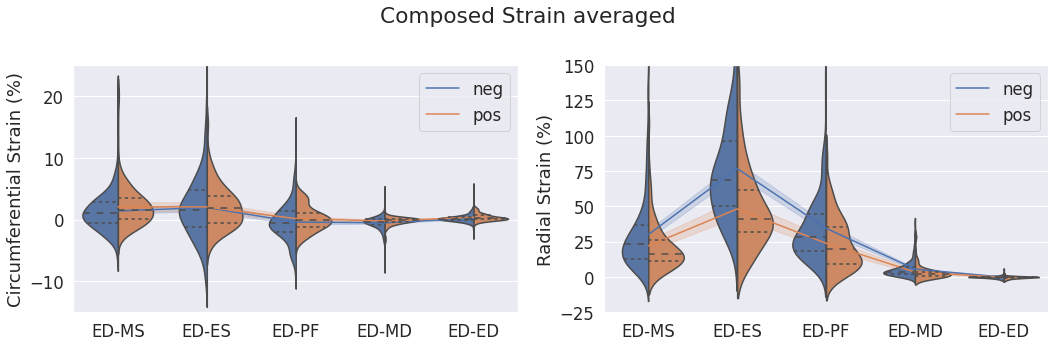

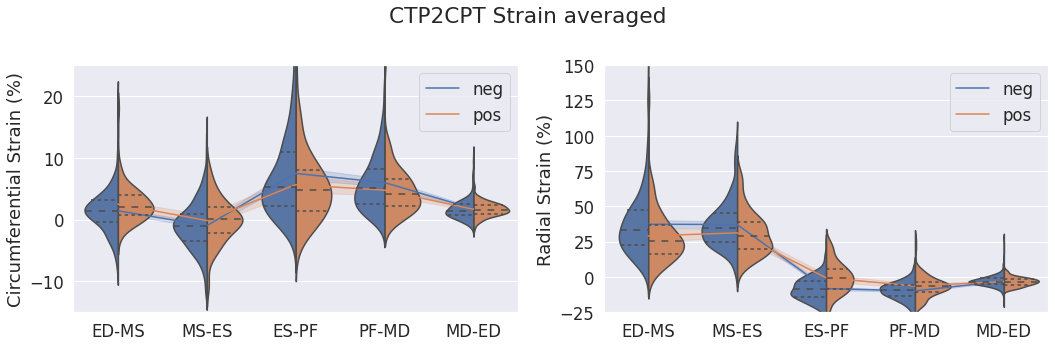

In [7]:
def plot_strain_per_time(df, title=None, p2p=False):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if p2p:
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    else:
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                 hue="lge",err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, split=True,hue='lge')
    _ = ax1.set_ylim((-15., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue="lge",err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, split=True,hue='lge')

    _ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig
    
#print('*'*20,'strain composed','*'*20)
_ = plot_strain_per_time(df_strain_comp,title='Composed Strain averaged',p2p=False); plt.show()
#print('*'*20,'strain p2p','*'*20)
_ = plot_strain_per_time(df_strain_p2p, title='CTP2CPT Strain averaged',p2p=True)

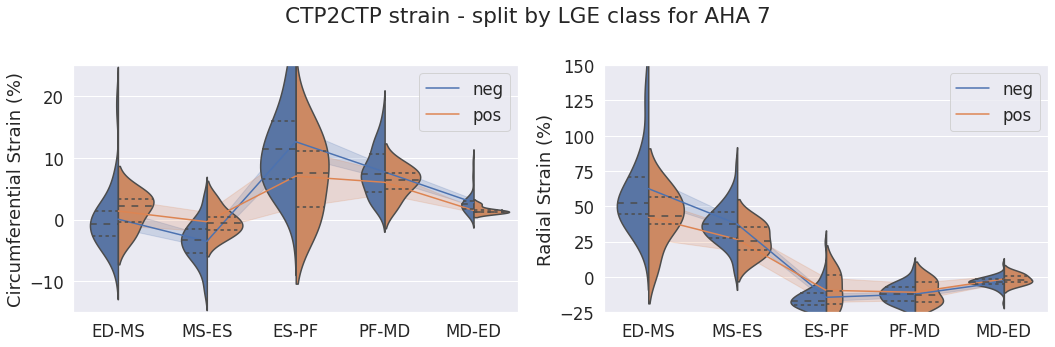

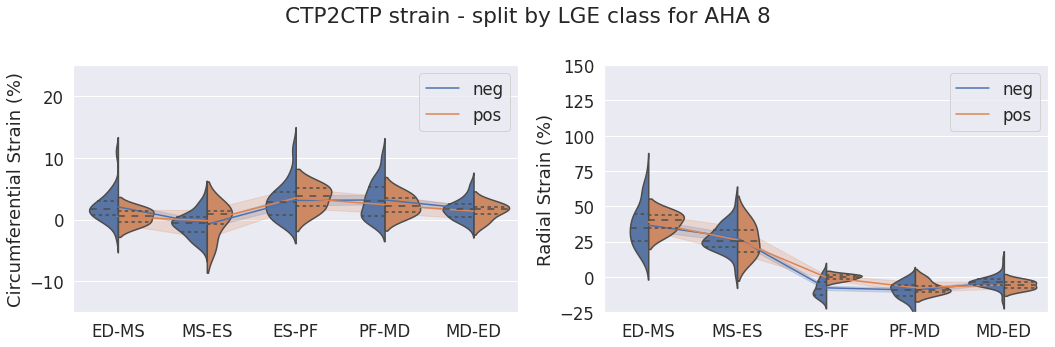

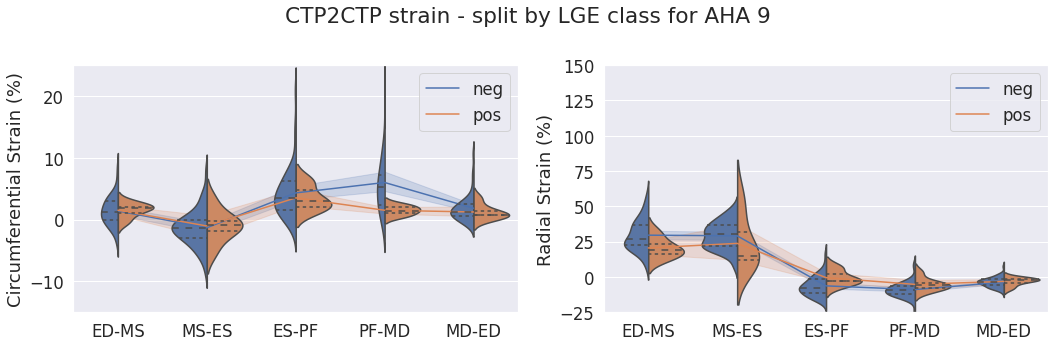

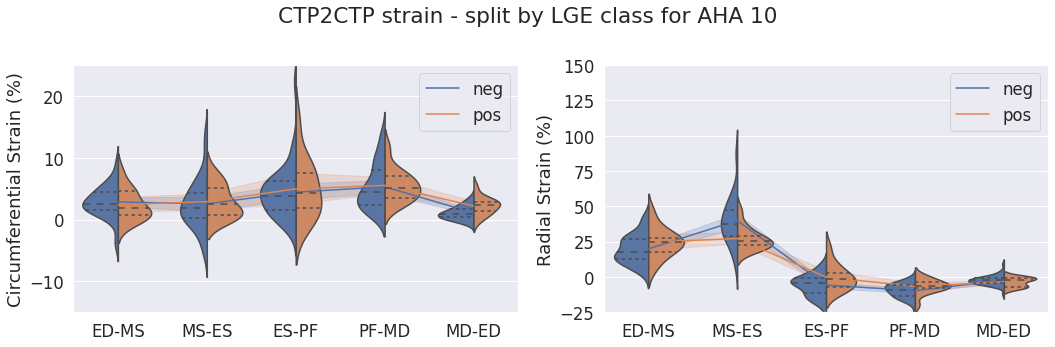

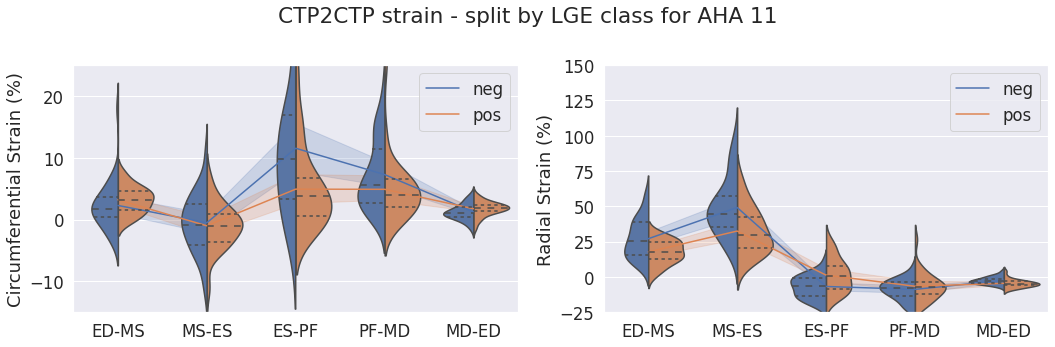

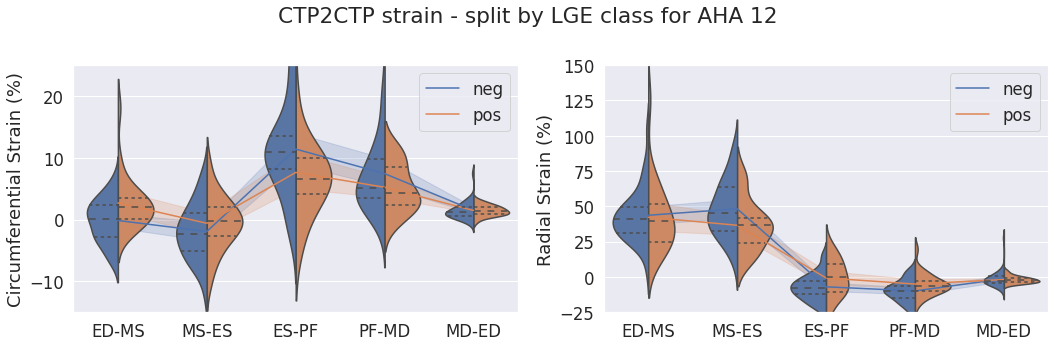

In [14]:
# plot one violinplot per mid-cavity segment for the p2p strains
for i in segments_of_interest:
    temp = df_strain_p2p[df_strain_p2p['aha']==i]
    _ = plot_strain_per_time(temp, title="CTP2CTP strain - split by LGE class for AHA {}".format(i), p2p=True)

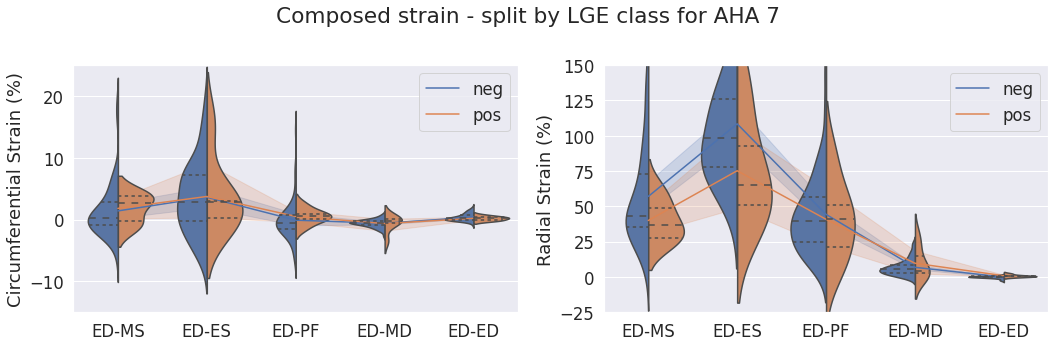

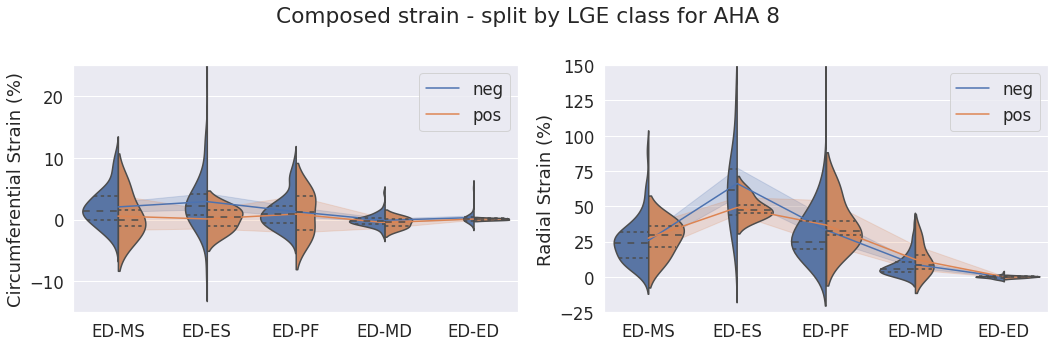

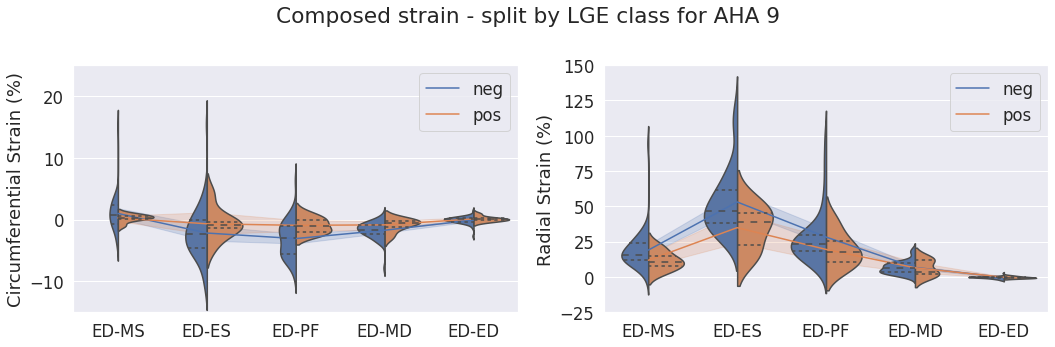

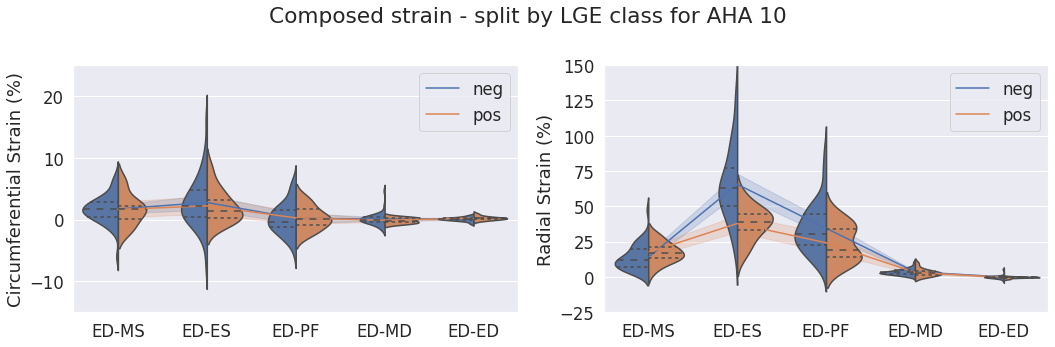

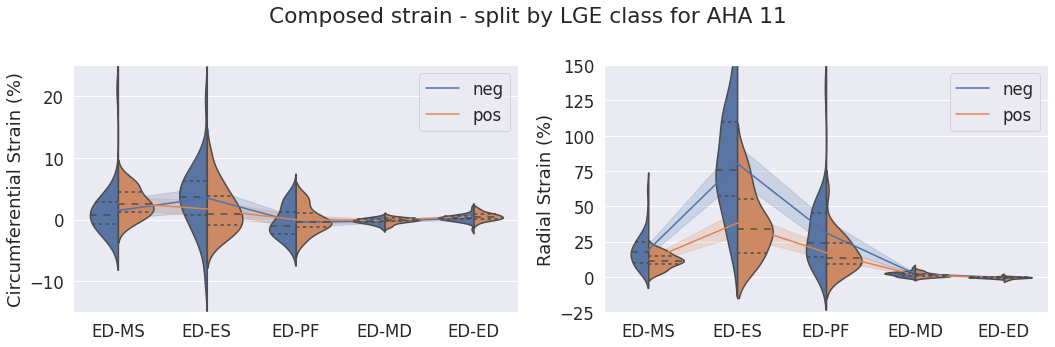

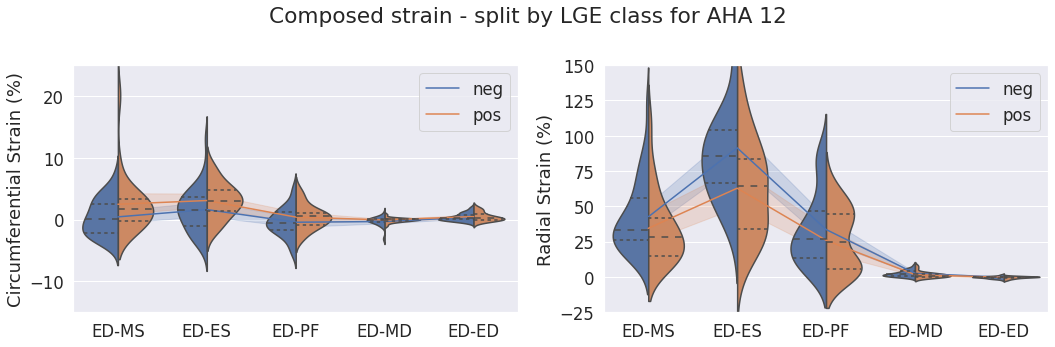

In [15]:
# plot one violinplot per mid-cavity segment for the p2p strains
for i in segments_of_interest:
    temp = df_strain_comp[df_strain_comp['aha']==i]
    _ = plot_strain_per_time(temp, title="Composed strain - split by LGE class for AHA {}".format(i), p2p=False)

In [76]:
#df_strain_comp.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
#df_strain_p2p.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [77]:
#df_strain_comp = df_strain_comp[~df_strain_comp['pat'].isin(['wc_20181015'])]
#df_strain_p2p = df_strain_p2p[~df_strain_p2p['pat'].isin(['wc_20181015'])]

# Identify pcs und prs 
- by max/min or by 
- a pre-defined phase (eg.: ES)

In [8]:
def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df_strain_comp.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df_strain_comp.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

# peak radial and circumferential strain
# for the composed and p2p strain values
prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)
    
# 56 patients x 16 segments = 896 --> Peak strain per patient and segment
df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

# composed phase
df_peak['prs_com_p']=prs_com_p
df_peak['pcs_com_p']=pcs_com_p
# composed arg-min/max
df_peak['prs_com_arg']=prs_com_arg
df_peak['pcs_com_arg']=pcs_com_arg
# p2p phase
df_peak['prs_p2p_p']=prs_p2p_p
df_peak['pcs_p2p_p']=pcs_p2p_p
# p2p arg-min/max
df_peak['prs_p2p_arg']=prs_p2p_arg
df_peak['pcs_p2p_arg']=pcs_p2p_arg
# minor cleaning and dtype casting
df_peak.drop(labels='phase', axis=1, inplace=True)
df_peak.drop(labels='our_rs', axis=1, inplace=True)
df_peak.drop(labels='our_cs', axis=1, inplace=True)
df_peak.sort_values(by=['pat', 'aha'], inplace=True)
df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
print(df_peak.dtypes)
print(df_peak.shape)

df_peak.head()

pat             object
aha            float32
soa            float32
lge            float32
prs_com_p      float32
pcs_com_p      float32
prs_com_arg    float32
pcs_com_arg    float32
prs_p2p_p      float32
pcs_p2p_p      float32
prs_p2p_arg    float32
pcs_p2p_arg    float32
dtype: object
(336, 12)


pat   aha  soa  lge  prs_com_p  pcs_com_p  prs_com_arg  \
30  aa_20180710   7.0  0.0  0.0   0.863641   0.021637     0.863641   
35  aa_20180710   8.0  0.0  0.0   0.581704   0.029333     0.581704   
40  aa_20180710   9.0  0.0  0.0   0.681309  -0.017546     0.681309   
45  aa_20180710  10.0  0.0  0.0   0.515717   0.001561     0.515717   
50  aa_20180710  11.0  0.0  0.0   0.753910   0.092065     0.753910   

    pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
30    -0.004952   0.322662  -0.025446     0.863641    -0.004952  
35    -0.004957   0.413836  -0.034243     0.581704    -0.004957  
40    -0.043987   0.467062   0.004811     0.681309    -0.043987  
45    -0.014001   0.586734   0.075549     0.515717    -0.014001  
50     0.001209   0.780717   0.009494     0.753910     0.001209

# Examples of dataframe grouby

In [9]:
temp_y = np.stack(df_strain_comp.groupby(['phase'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(5, 336)
LGE positive patients:  78
LGE negative patients:  258


In [10]:
temp_y = np.stack(df_strain_comp.groupby(['phase','aha'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=0)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(30, 56)
LGE positive patients:  28
LGE negative patients:  28


In [11]:
temp_y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive segments: ',(temp_y==True).sum())
print('LGE negative segments: ',(temp_y==False).sum())
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 30)
LGE positive segments:  390
LGE negative segments:  1290
LGE positive patients:  28
LGE negative patients:  28


In [12]:
temp_y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32)
print(temp_y.shape)
temp_y_patients = temp_y.sum(axis=1)>0
print('LGE positive patients: ',(temp_y_patients==True).sum())
print('LGE negative patients: ',(temp_y_patients==False).sum())

(56, 6)
LGE positive patients:  28
LGE negative patients:  28


# Peak Strain via argmax or static phase slicing

Phases: [0:4] --> ED,MS,ES,PF,MD
Usually min(cs) and max(rs) should reflect the phase MS--> ES, which sould be phase==1

In [58]:
# peak strain values per LGE positive group
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_peak_positive = df_peak[df_peak['lge']==1] * 100
df_peak_positive.describe()

aha      soa      lge  prs_com_p  pcs_com_p  prs_com_arg  \
count   78.0000  78.0000  78.0000    78.0000    78.0000      78.0000   
mean  1047.4359  43.5897 100.0000    48.2036     2.0523      50.1766   
std    150.0860  49.9083   0.0000    28.3565     3.4868      28.5508   
min    700.0000   0.0000 100.0000     8.7956    -4.3634      10.7933   
25%   1000.0000   0.0000 100.0000    32.2004    -0.5266      32.5152   
50%   1100.0000   0.0000 100.0000    40.7496     1.8929      42.8920   
75%   1200.0000 100.0000 100.0000    61.8252     3.8715      62.2497   
max   1200.0000 100.0000 100.0000   137.9361    15.4617     137.9361   

       pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
count      78.0000    78.0000    78.0000      78.0000      78.0000  
mean       -1.0348    31.2496    -0.1454      50.1766      -1.0348  
std         1.1312    15.4448     3.6635      28.5508       1.1312  
min        -4.3634     5.8785   -11.0129      10.7933      -4.3634  
25%        -1.7014    19.8176    -2.1813      32.5152      -1.7014  
50%        -0.8004    28.9589     0.0476      42.8920      -0.8004  
75%        -0.1393    39.0445     2.0351      62.2497      -0.1393  
max         0.3547    73.2134     8.7593     137.9361       0.3547

In [59]:
# peak strain values per LGE negative group
df_peak_negative = df_peak[df_peak['lge']==0] * 100
df_peak_negative.describe()

aha      soa      lge  prs_com_p  pcs_com_p  prs_com_arg  \
count  258.0000 258.0000 258.0000   258.0000   258.0000     258.0000   
mean   920.5427  11.2403   0.0000    76.7968     1.9611      77.8534   
std    166.2253  31.6476   0.0000    39.5381     5.2241      39.6016   
min    700.0000   0.0000   0.0000    15.9752   -10.6958      15.9752   
25%    800.0000   0.0000   0.0000    50.1149    -1.2588      50.6790   
50%    900.0000   0.0000   0.0000    68.7376     1.4835      69.4601   
75%   1000.0000   0.0000   0.0000    96.5035     4.7601      97.7033   
max   1200.0000 100.0000   0.0000   266.3976    26.0798     266.3976   

       pcs_com_arg  prs_p2p_p  pcs_p2p_p  prs_p2p_arg  pcs_p2p_arg  
count     258.0000   258.0000   258.0000     258.0000     258.0000  
mean       -1.9837    37.1276    -0.9778      77.8534      -1.9837  
std         2.1597    16.9007     3.9878      39.6016       2.1597  
min       -10.6958     1.1377   -11.9531      15.9752     -10.6958  
25%        -2.9385    24.8867    -3.4116      50.6790      -2.9385  
50%        -1.2956    34.4954    -1.0076      69.4601      -1.2956  
75%        -0.4031    45.2791     0.9472      97.7033      -0.4031  
max         0.9186    98.8759    14.0309     266.3976       0.9186

In [71]:
# segment and phase with the maximal difference between LGE pos and negative group
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
temp_pos = df_strain_p2p_positive.groupby(['aha','phase']).mean()

df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
temp_neg = df_strain_p2p_negative.groupby(['aha','phase']).mean()

diff = abs(temp_pos - temp_neg)*100
diff[['our_rs', 'our_cs']]

our_rs  our_cs
aha phase                
7   0     20.0437  1.3169
    1     10.8220  3.1815
    2      4.9525  5.5623
    3      1.3188  1.6697
    4      2.0764  1.2614
8   0      2.2642  1.5463
    1      1.3532  0.5822
    2      7.4943  0.3980
    3      1.7795  0.7655
    4      2.2593  0.3362
9   0      9.0567  0.1233
    1      5.3537  0.2890
    2      5.8356  0.7995
    3      3.6626  4.4957
    4      0.5206  0.6079
10  0      4.6744  0.4656
    1     12.7252  0.3666
    2      5.6308  0.5380
    3      3.1249  0.2224
    4      1.1804  1.1151
11  0      9.3296  0.9143
    1     16.6694  0.4899
    2      8.0521  6.6154
    3      2.2024  2.3840
    4      2.1323  0.5386
12  0      1.3648  2.8444
    1     11.6912  1.3289
    2      6.2754  3.7790
    3      4.8953  2.2050
    4      0.6125  0.0198

******************** strain composed ********************
prs: Counter({1: 302, 2: 21, 0: 13})
pcs: Counter({2: 116, 3: 98, 1: 51, 0: 36, 4: 35})


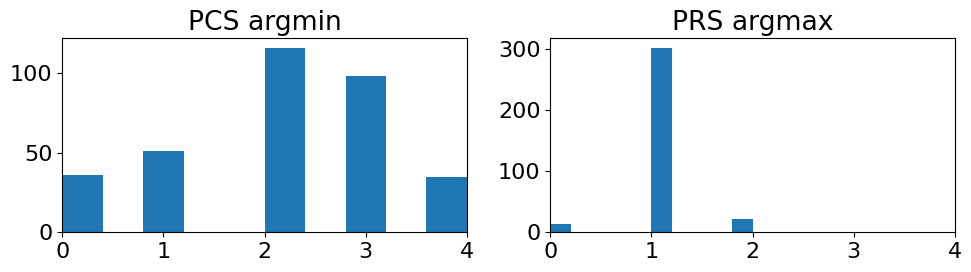

******************** strain p2p ********************
prs: Counter({1: 177, 0: 158, 2: 1})
pcs: Counter({1: 204, 4: 51, 0: 46, 2: 26, 3: 9})


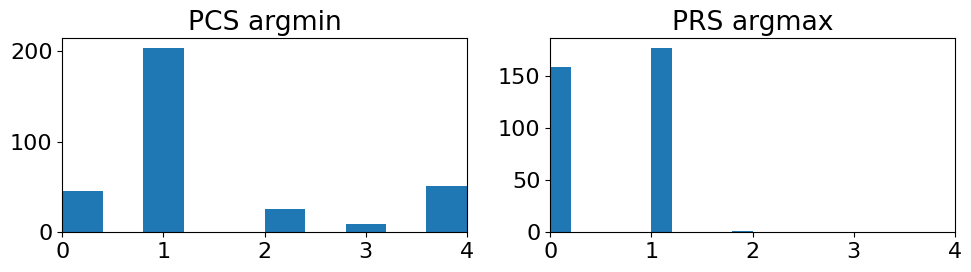

In [62]:
def show_phase_with_max_min_strain(df):
    from collections import Counter
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    # peak radial strain
    rs = np.stack(df.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32)
    # peak circumferential strain
    cs = np.stack(df.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32)

    prs_argmax = np.argmax(rs, axis=1)
    pcs_argmin = np.argmin(cs, axis=1)
    print('prs: {}'.format(Counter(prs_argmax)))
    print('pcs: {}'.format(Counter(pcs_argmin)))

    # plot
    ax[0].hist(pcs_argmin)
    ax[0].set_title('PCS argmin')
    ax[0].set_xlim(0,4)
    ax[1].hist(prs_argmax)
    ax[1].set_title('PRS argmax')
    ax[1].set_xlim(0,4)
    plt.tight_layout()
    plt.show()
    
print('*'*20,'strain composed','*'*20)
show_phase_with_max_min_strain(df_strain_comp)
print('*'*20,'strain p2p','*'*20)
show_phase_with_max_min_strain(df_strain_p2p)

prs: Counter({1: 43, 0: 34, 2: 1})
pcs: Counter({1: 43, 0: 12, 4: 11, 2: 9, 3: 3})


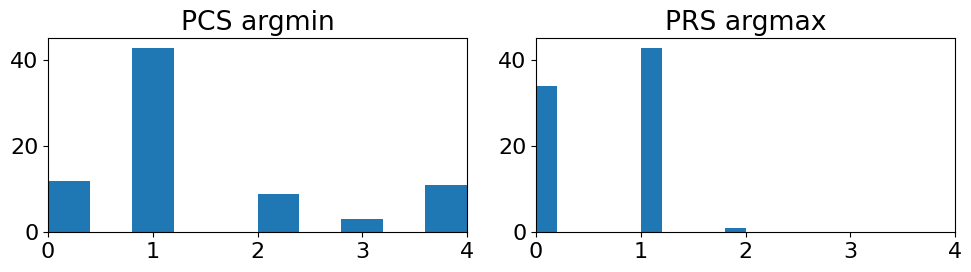

prs: Counter({1: 134, 0: 124})
pcs: Counter({1: 161, 4: 40, 0: 34, 2: 17, 3: 6})


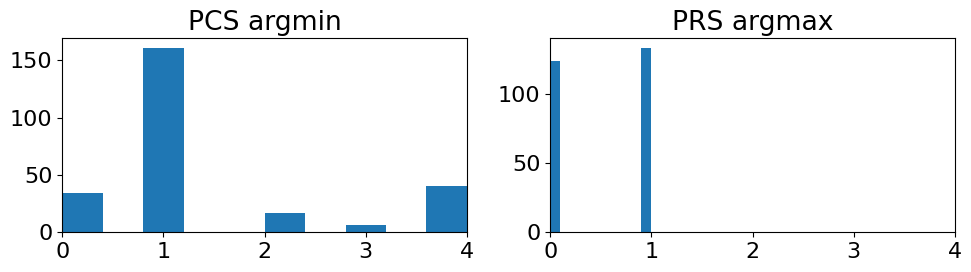

prs: Counter({1: 64, 2: 9, 0: 5})
pcs: Counter({2: 27, 3: 24, 1: 11, 4: 9, 0: 7})


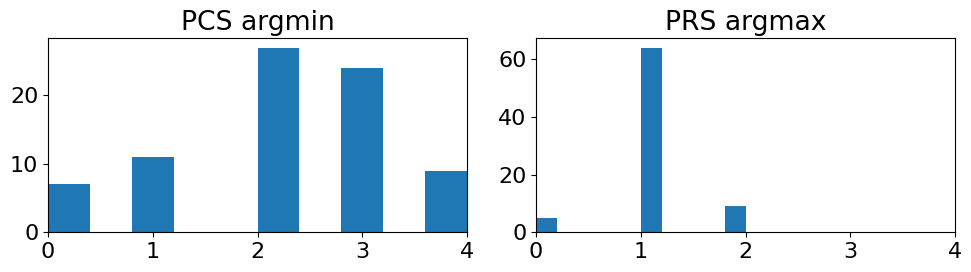

prs: Counter({1: 238, 2: 12, 0: 8})
pcs: Counter({2: 89, 3: 74, 1: 40, 0: 29, 4: 26})


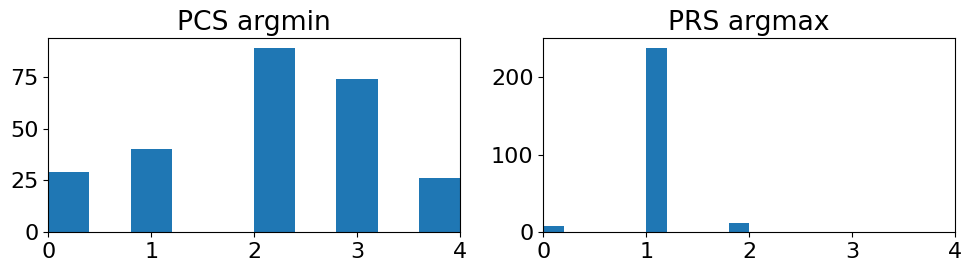

In [64]:
# occurence of the peak and min values per outcome group and strain
df_strain_p2p_positive = df_strain_p2p[df_strain_p2p['lge']==1]
df_strain_p2p_negative = df_strain_p2p[df_strain_p2p['lge']==0]
show_phase_with_max_min_strain(df_strain_p2p_positive)
show_phase_with_max_min_strain(df_strain_p2p_negative)

df_strain_comp_positive = df_strain_comp[df_strain_comp['lge']==1]
df_strain_comp_negative = df_strain_comp[df_strain_comp['lge']==0]
show_phase_with_max_min_strain(df_strain_comp_positive)
show_phase_with_max_min_strain(df_strain_comp_negative)

# Pairplot

## Composed Strain

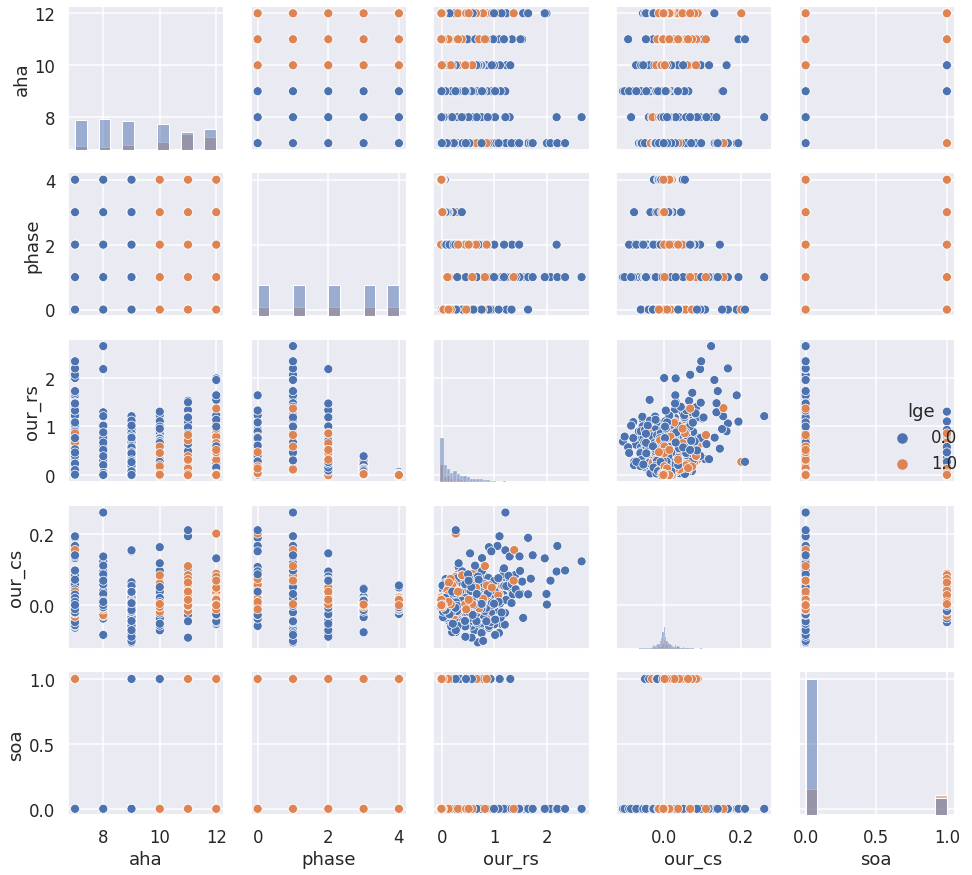

In [14]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_comp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## p2p Strain

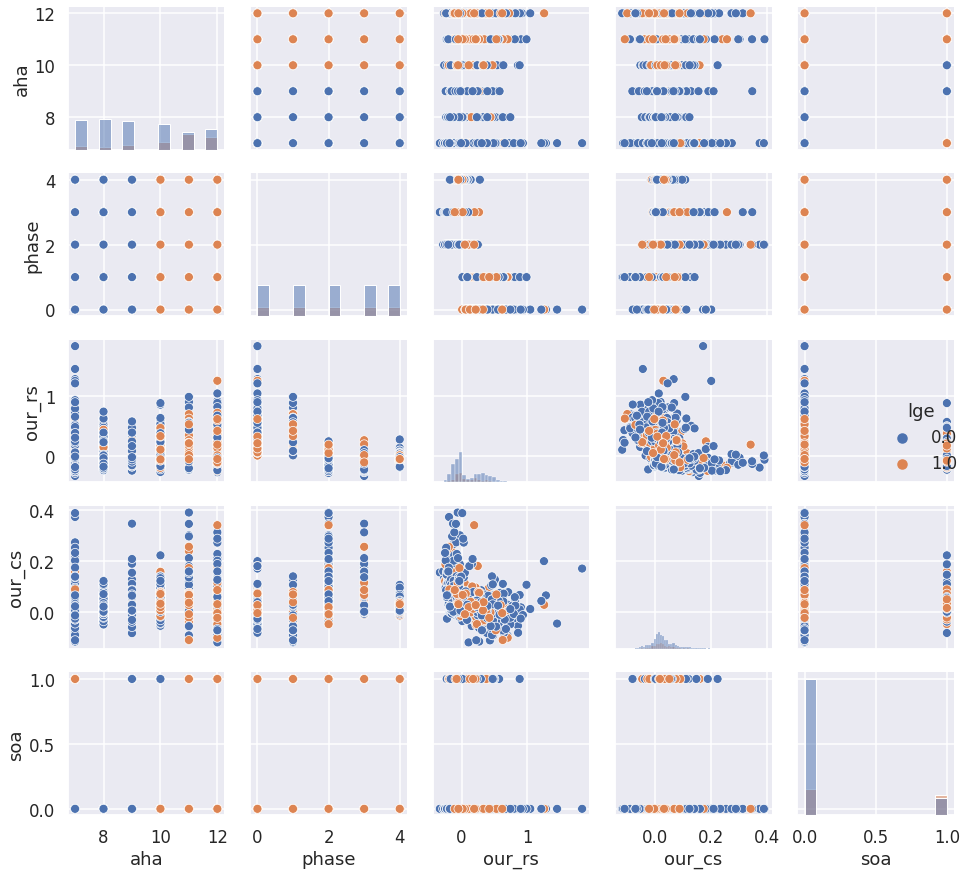

In [15]:
sb.set_context("talk")
g = sb.pairplot(data=df_strain_p2p,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

## Peak Strain

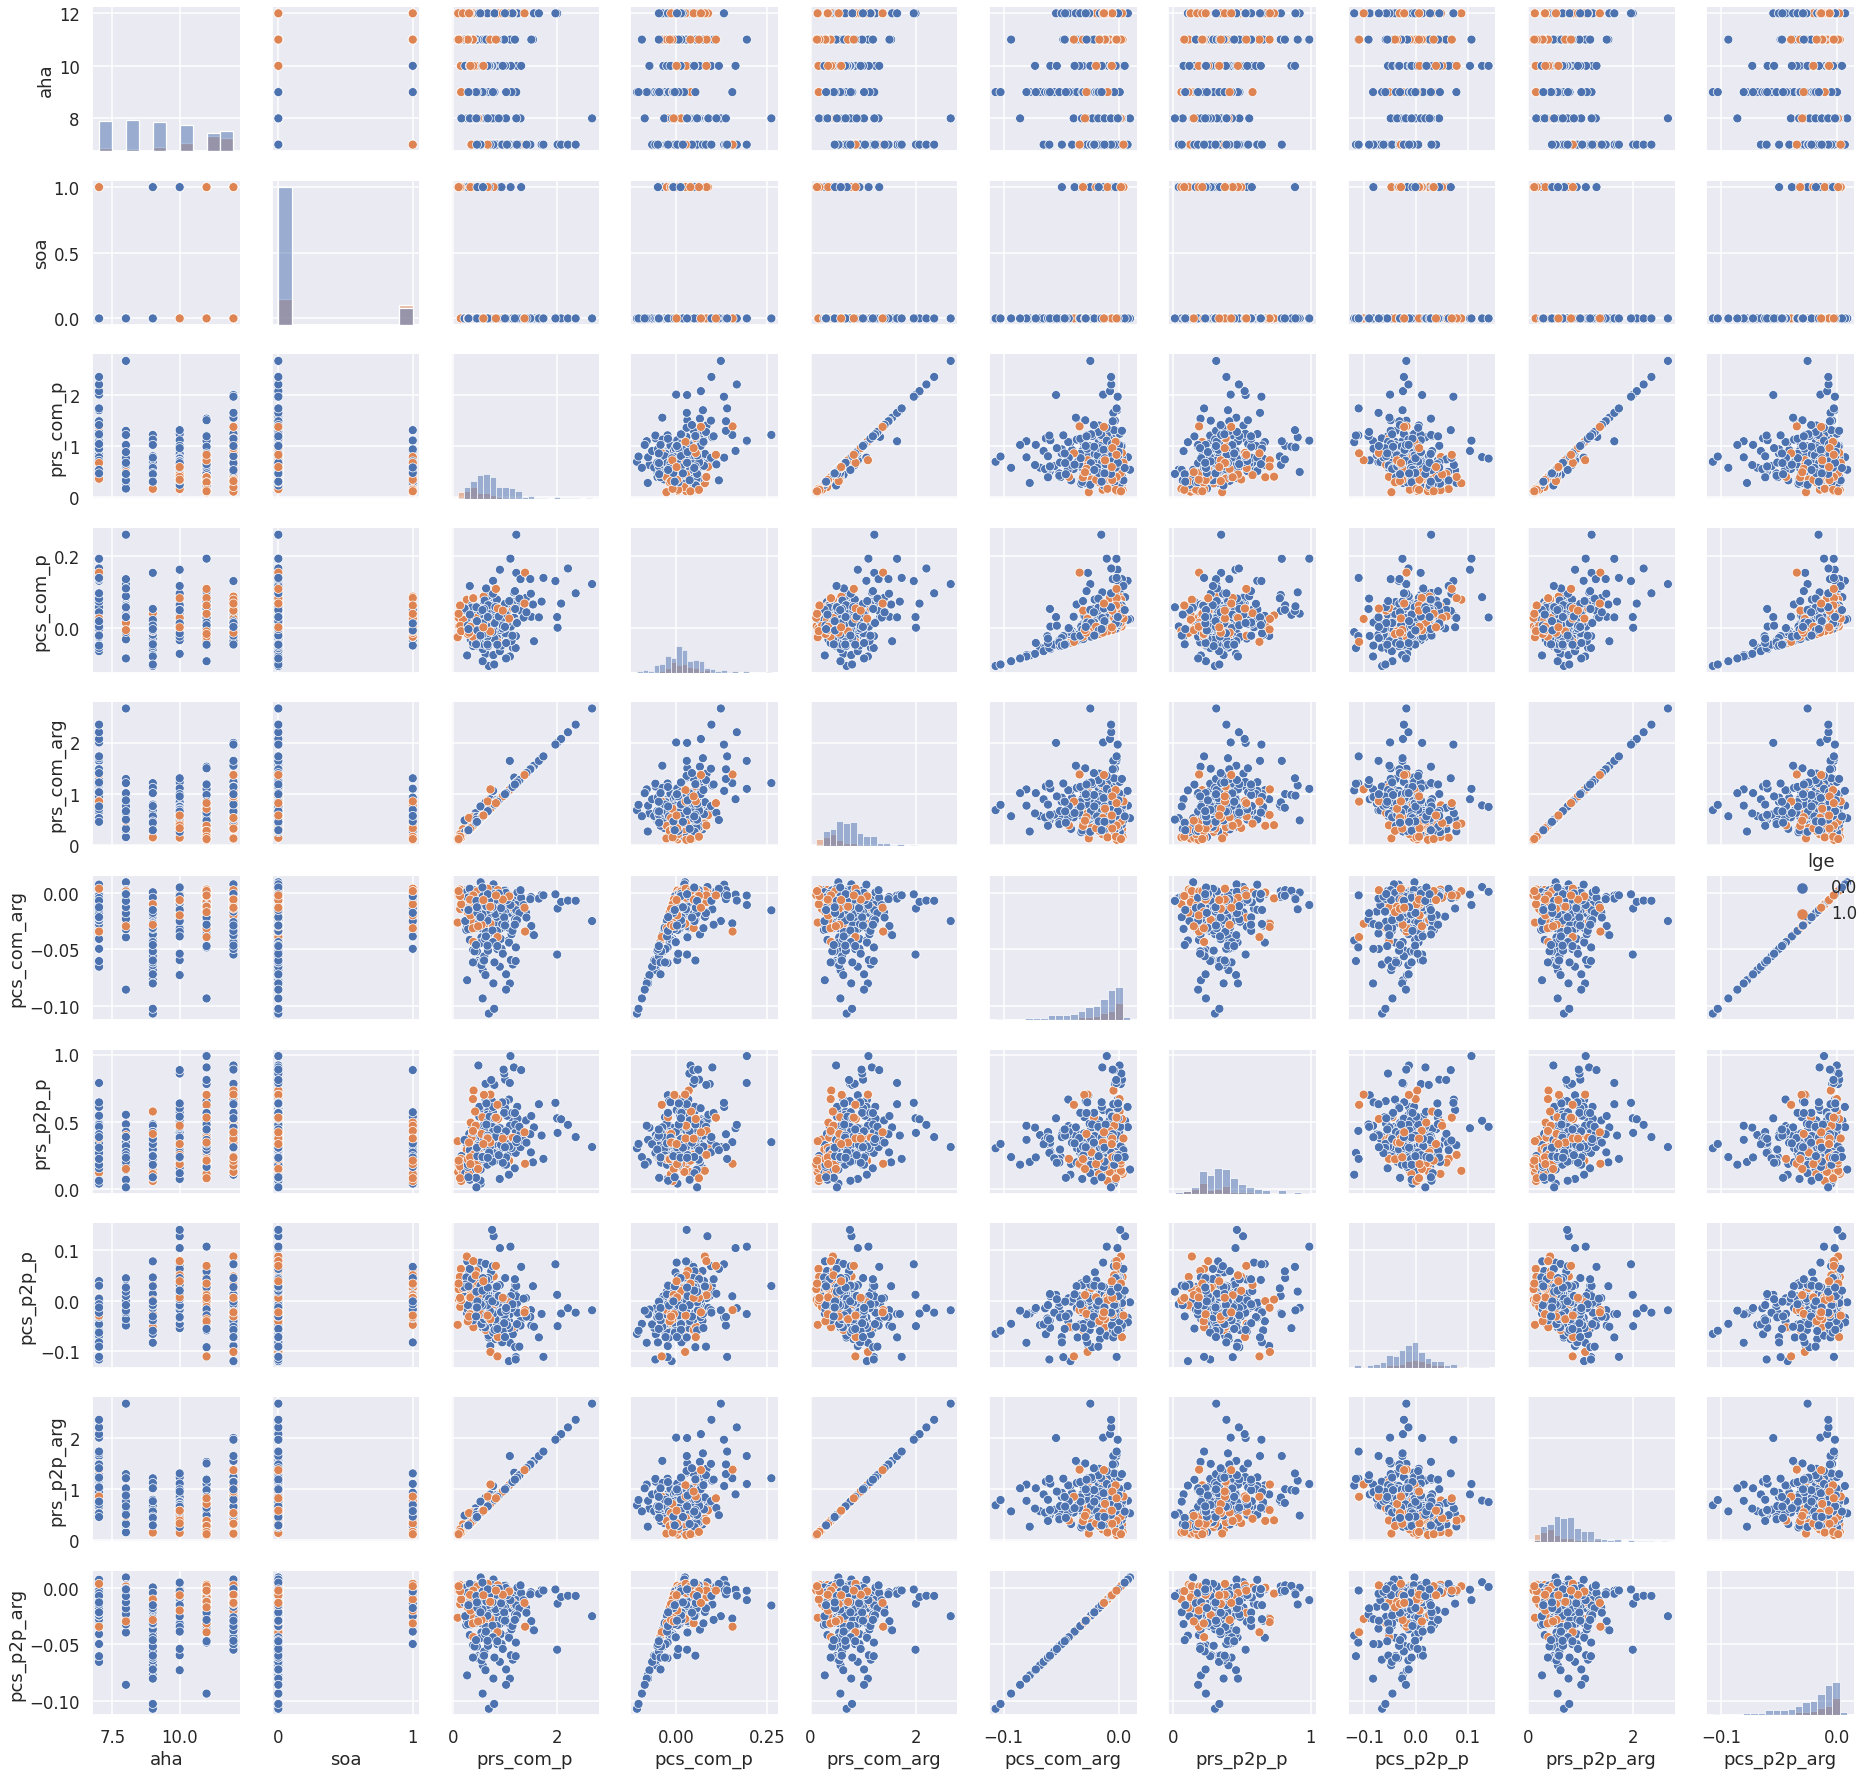

In [16]:
sb.set_context("talk")
g = sb.pairplot(data=df_peak,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

# Correlation plots

## Composed Strain

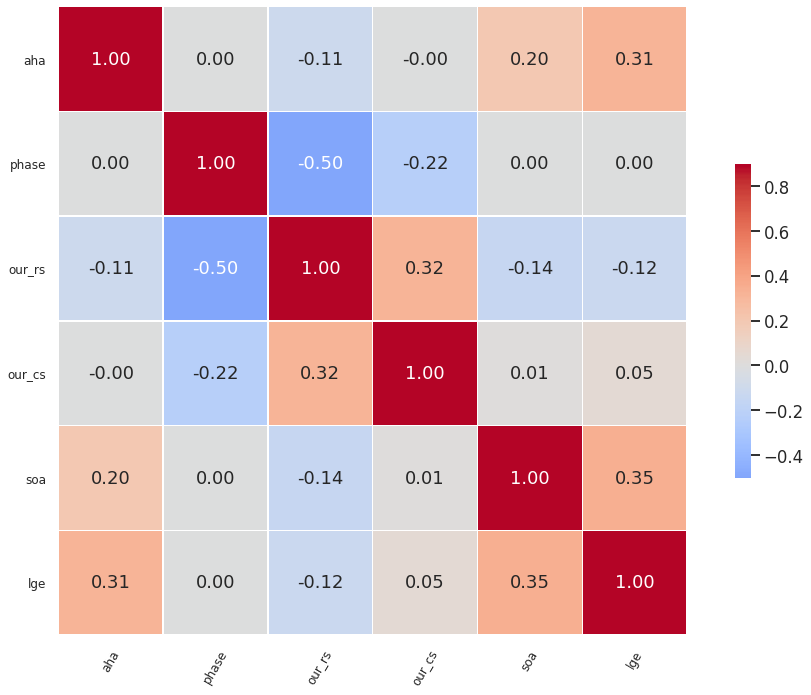

In [17]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_comp.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()
#fig.savefig('strain_corr_cvi_vs_ours.png')

## p2p Strain

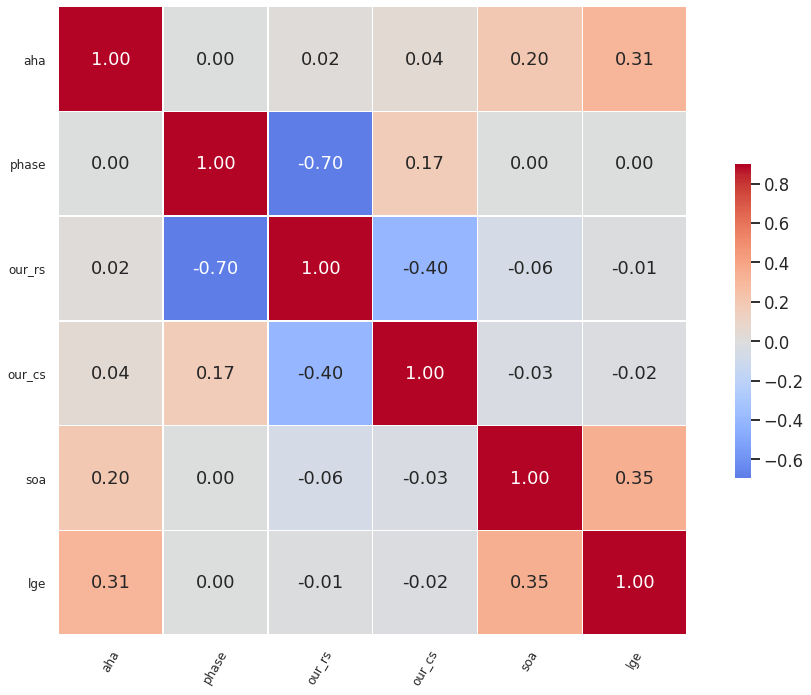

In [18]:
fig, ax = plt.subplots(figsize=(14,10)) 
corr = df_strain_p2p.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

## Peak Strain

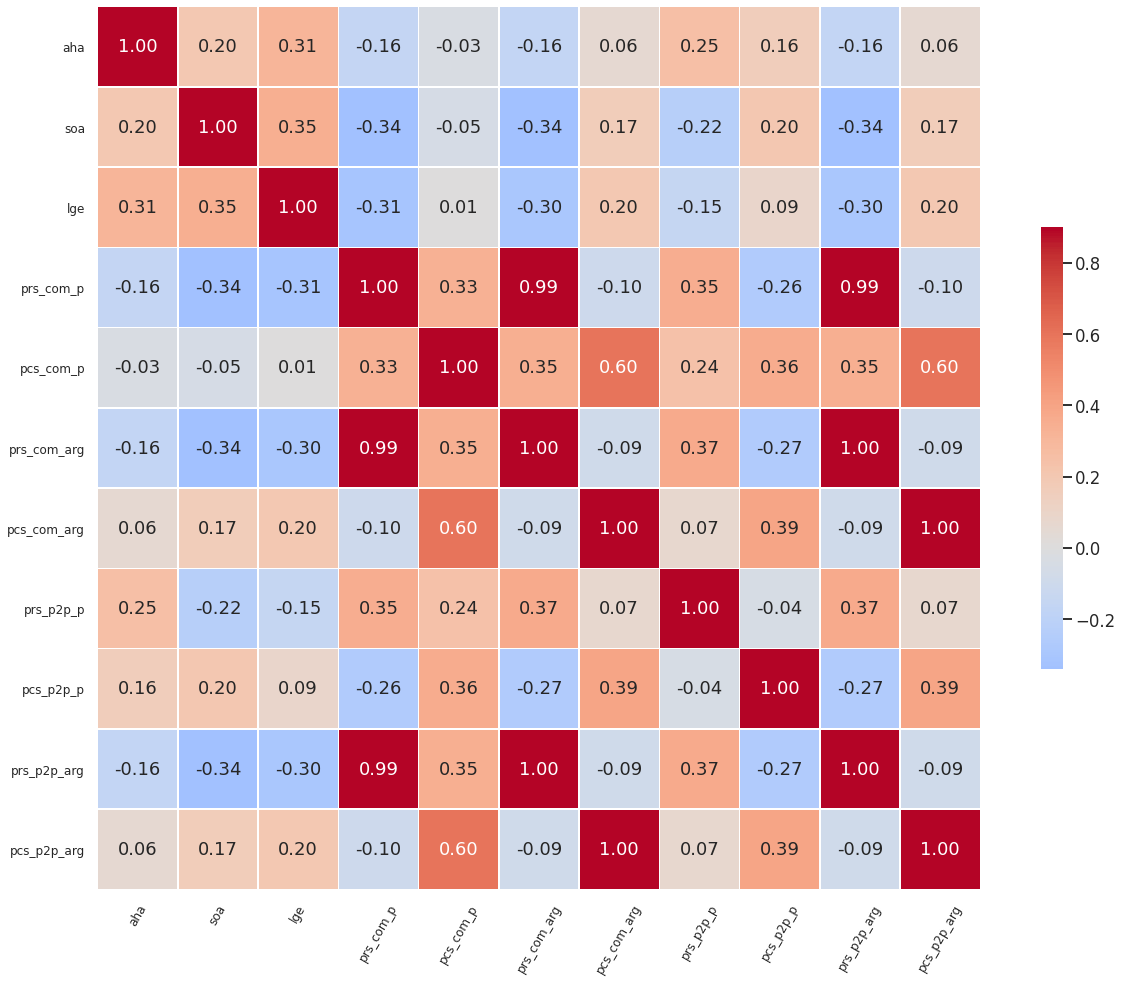

In [19]:
fig, ax = plt.subplots(figsize=(18,14)) 
corr = df_peak.corr(method='pearson')
g = sb.heatmap(corr,  vmax=.9, center=0,ax=ax,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 12)
_ = g.set_xticklabels(g.get_xticklabels(), rotation = 60, fontsize = 12)
plt.tight_layout()

# Strain per phase

Extract one feature Vector per Patient (56 patients times 16 segments times 5 phases times two feature (rs, cs))

- 32 LGE positive patients
- 24 LGE negative patients

## Strain per patient from composed df (56 x 16 x 5 x 2) --> 56, 160

(56, 30)
(56, 60)
(56, 30)
(56,)
********** Logistic Regression **********
[1.         1.         1.         0.83333333 0.33333333]
Recall: 0.83 (+/- 0.26) [Logistic Regression]
Accuracy: 0.79 (+/- 0.19) [Logistic Regression]
********** Random Forest **********
[1.         0.8        0.8        0.5        0.33333333]
Recall: 0.69 (+/- 0.24) [Random Forest]
Accuracy: 0.70 (+/- 0.09) [Random Forest]
********** naive Bayes **********
[1.  1.  0.8 0.5 0.5]
Recall: 0.76 (+/- 0.22) [naive Bayes]
Accuracy: 0.68 (+/- 0.09) [naive Bayes]
********** scaled DecissionTree **********
[0.5        0.8        0.6        0.66666667 0.33333333]
Recall: 0.58 (+/- 0.16) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.12) [scaled DecissionTree]
********** KNN **********
[0.66666667 0.4        0.6        0.33333333 0.5       ]
Recall: 0.50 (+/- 0.12) [KNN]
Accuracy: 0.54 (+/- 0.13) [KNN]
********** scaled SVC(poly) **********
[1.  1.  0.6 1.  1. ]
Recall: 0.92 (+/- 0.16) [scaled SVC(poly)]
Accuracy: 0.64 (+/- 

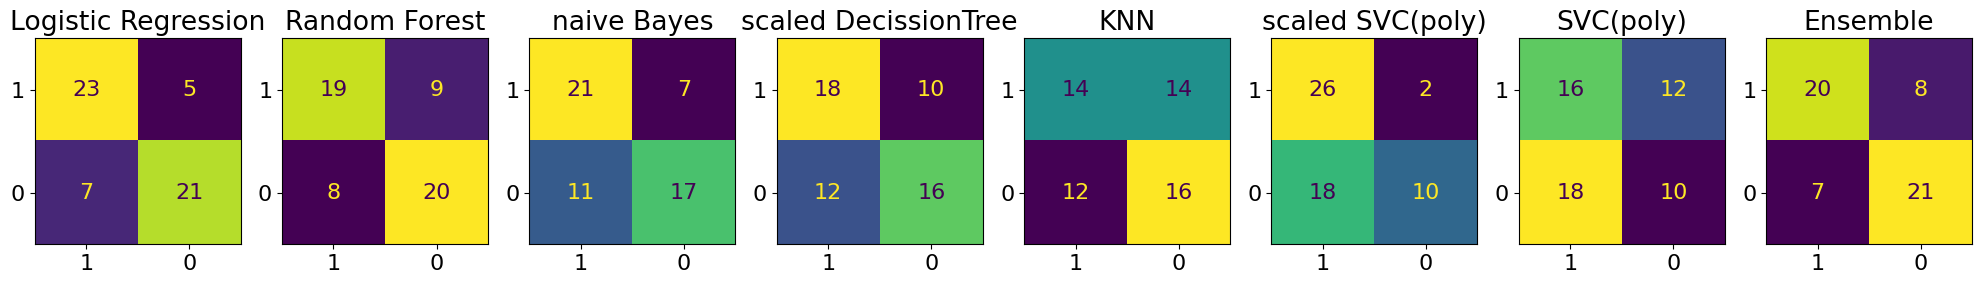

In [37]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_comp.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p df (56 x 16 x 5 x 2) --> 56, 160

(56, 20)
(56, 40)
(56, 20)
(56,)
********** Logistic Regression **********
[0.42857143 0.66666667 0.5        0.66666667 0.71428571]
Recall: 0.60 (+/- 0.11) [Logistic Regression]
Accuracy: 0.61 (+/- 0.12) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.66666667 0.66666667 0.83333333 1.        ]
Recall: 0.78 (+/- 0.13) [Random Forest]
Accuracy: 0.65 (+/- 0.18) [Random Forest]
********** naive Bayes **********
[0.57142857 0.5        0.5        0.5        0.71428571]
Recall: 0.56 (+/- 0.08) [naive Bayes]
Accuracy: 0.59 (+/- 0.13) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.66666667 0.5        0.83333333 1.        ]
Recall: 0.71 (+/- 0.18) [scaled DecissionTree]
Accuracy: 0.63 (+/- 0.17) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.33333333 0.83333333 0.66666667 0.57142857]
Recall: 0.60 (+/- 0.16) [KNN]
Accuracy: 0.63 (+/- 0.07) [KNN]
********** scaled SVC(poly) **********
[0.85714286 0.83333333 0.83333333 0.83333333 1.   

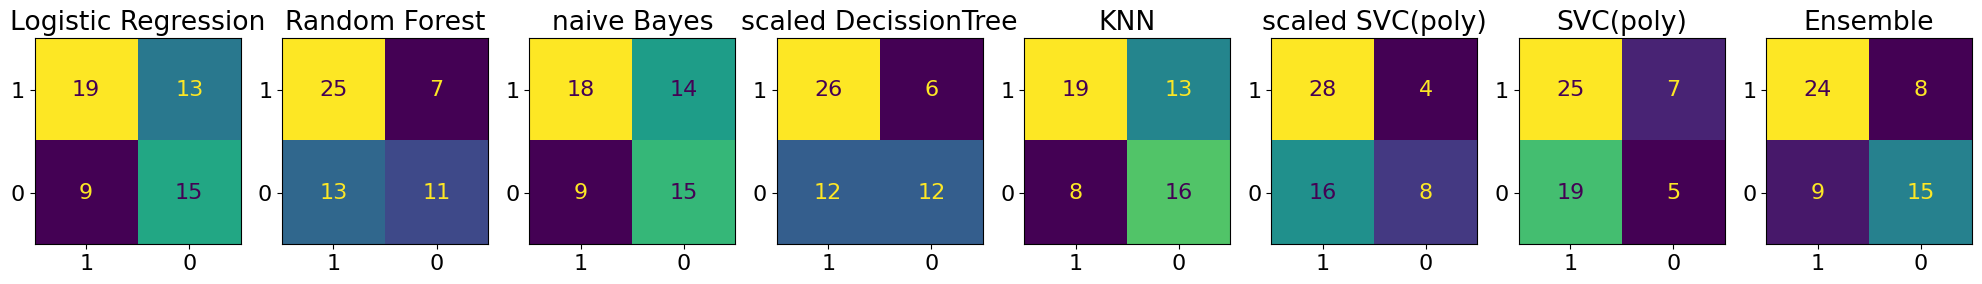

In [135]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_p2p.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_p2p.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain per patient from p2p & composed df (56 x 16 x 5 x 2 x 2) --> 56, 320

# Peak Strain

- p2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

- ed2p
cs x 16 segments x 5 phases (80) & rs x 16 segments x 5 phases (80) --> 160 features per patient

--> 320 features per patient

(56, 30)
(56, 120)
(56, 30)
(56,)
********** Logistic Regression **********
[1.         0.8        0.6        0.83333333 0.5       ]
Recall: 0.75 (+/- 0.18) [Logistic Regression]
Accuracy: 0.78 (+/- 0.09) [Logistic Regression]
********** Random Forest **********
[0.83333333 0.8        0.6        0.66666667 0.66666667]
Recall: 0.71 (+/- 0.09) [Random Forest]
Accuracy: 0.75 (+/- 0.04) [Random Forest]
********** naive Bayes **********
[1.  1.  0.6 0.5 0.5]
Recall: 0.72 (+/- 0.23) [naive Bayes]
Accuracy: 0.71 (+/- 0.09) [naive Bayes]
********** scaled DecissionTree **********
[0.66666667 0.8        0.6        0.5        0.66666667]
Recall: 0.65 (+/- 0.10) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.09) [scaled DecissionTree]
********** KNN **********
[0.66666667 0.4        0.6        0.66666667 0.66666667]
Recall: 0.60 (+/- 0.10) [KNN]
Accuracy: 0.63 (+/- 0.06) [KNN]
********** scaled SVC(poly) **********
[1. 1. 1. 1. 1.]
Recall: 1.00 (+/- 0.00) [scaled SVC(poly)]
Accuracy: 0.59 (+/- 0.08

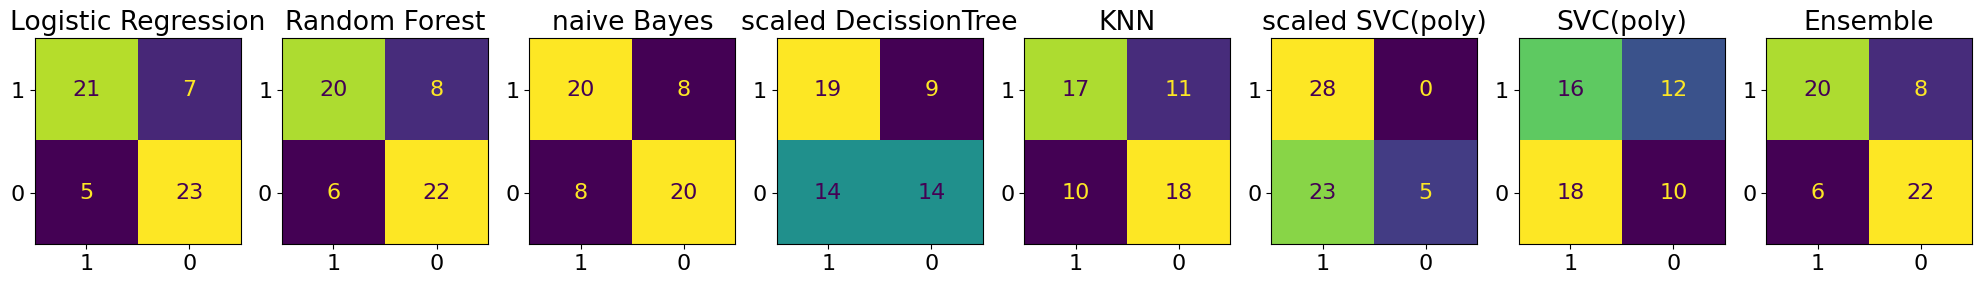

In [38]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc_p = np.stack(df_strain_p2p.groupby(['pat'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr_p = np.stack(df_strain_p2p.groupby(['pat'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr, xc_p, xr_p], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_p2p.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from composed df

(56, 6)
(56, 12)
(56, 6)
(56,)
********** Logistic Regression **********
[1.         1.         1.         0.83333333 0.5       ]
Recall: 0.87 (+/- 0.19) [Logistic Regression]
Accuracy: 0.80 (+/- 0.15) [Logistic Regression]
********** Random Forest **********
[0.83333333 0.8        1.         0.83333333 0.5       ]
Recall: 0.79 (+/- 0.16) [Random Forest]
Accuracy: 0.79 (+/- 0.14) [Random Forest]
********** naive Bayes **********
[1.         1.         1.         0.83333333 0.33333333]
Recall: 0.83 (+/- 0.26) [naive Bayes]
Accuracy: 0.75 (+/- 0.15) [naive Bayes]
********** scaled DecissionTree **********
[0.83333333 0.8        1.         0.66666667 0.33333333]
Recall: 0.73 (+/- 0.22) [scaled DecissionTree]
Accuracy: 0.73 (+/- 0.10) [scaled DecissionTree]
********** KNN **********
[1.  0.8 0.8 0.5 0.5]
Recall: 0.72 (+/- 0.19) [KNN]
Accuracy: 0.68 (+/- 0.08) [KNN]
********** scaled SVC(poly) **********
[1. 1. 1. 1. 1.]
Recall: 1.00 (+/- 0.00) [scaled SVC(poly)]
Accuracy: 0.72 (+/- 0.06) [

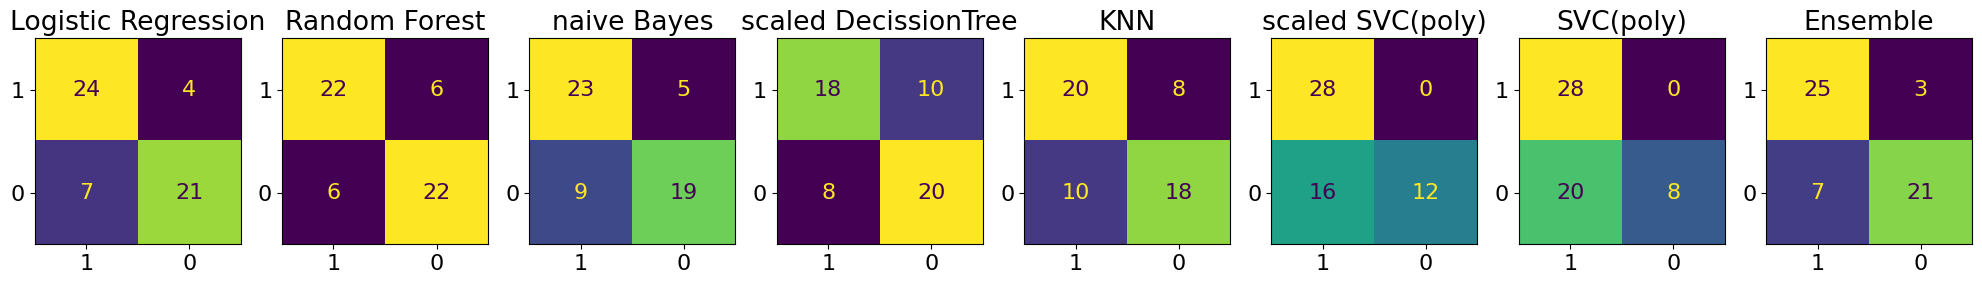

In [20]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (arg-min/max) per patient from composed df

(56, 4)
(56, 8)
(56, 4)
(56,)
********** Logistic Regression **********
[0.57142857 1.         0.83333333 0.83333333 0.85714286]
Recall: 0.82 (+/- 0.14) [Logistic Regression]
Accuracy: 0.74 (+/- 0.19) [Logistic Regression]
********** Random Forest **********
[0.42857143 0.83333333 0.66666667 0.66666667 0.85714286]
Recall: 0.69 (+/- 0.15) [Random Forest]
Accuracy: 0.63 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[0.71428571 1.         0.66666667 0.66666667 1.        ]
Recall: 0.81 (+/- 0.16) [naive Bayes]
Accuracy: 0.63 (+/- 0.17) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.5        0.33333333 0.66666667 1.        ]
Recall: 0.59 (+/- 0.23) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.5        0.5        0.5        0.57142857]
Recall: 0.50 (+/- 0.05) [KNN]
Accuracy: 0.59 (+/- 0.06) [KNN]
********** scaled SVC(poly) **********
[0.71428571 1.         1.         0.66666667 1.      

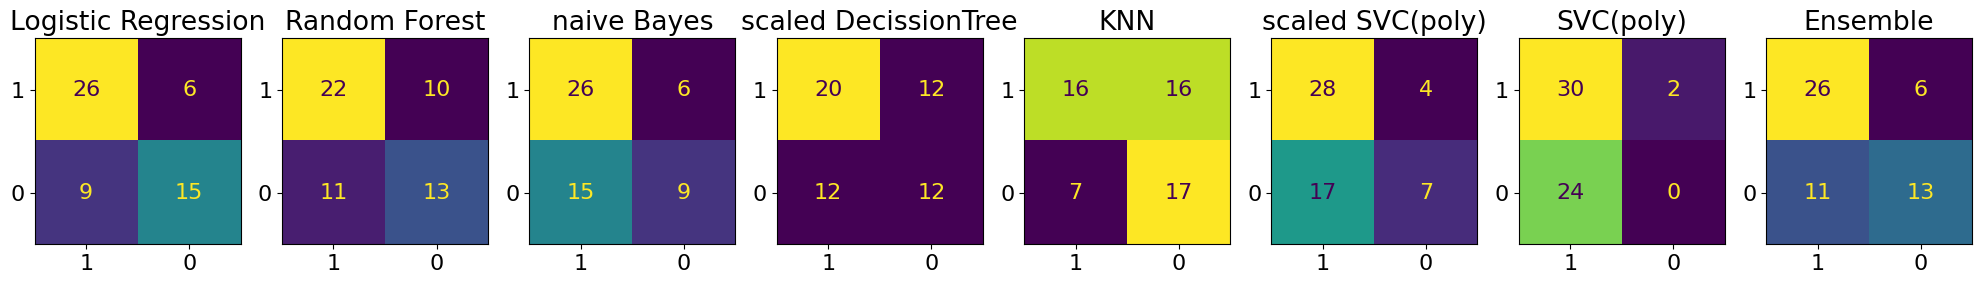

In [138]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## Strain (Phase) per patient from p2p df

(56, 4)
(56, 8)
(56, 4)
(56,)
********** Logistic Regression **********
[0.42857143 0.66666667 0.83333333 0.83333333 0.57142857]
Recall: 0.67 (+/- 0.16) [Logistic Regression]
Accuracy: 0.64 (+/- 0.06) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.83333333 0.83333333 0.83333333 0.85714286]
Recall: 0.81 (+/- 0.05) [Random Forest]
Accuracy: 0.68 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[0.71428571 0.66666667 0.83333333 0.83333333 0.71428571]
Recall: 0.75 (+/- 0.07) [naive Bayes]
Accuracy: 0.70 (+/- 0.09) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.5        0.66666667 0.83333333 0.57142857]
Recall: 0.66 (+/- 0.12) [scaled DecissionTree]
Accuracy: 0.59 (+/- 0.07) [scaled DecissionTree]
********** KNN **********
[0.14285714 0.33333333 0.83333333 0.83333333 0.28571429]
Recall: 0.49 (+/- 0.29) [KNN]
Accuracy: 0.56 (+/- 0.13) [KNN]
********** scaled SVC(poly) **********
[0.85714286 1.         1.         0.83333333 1.      

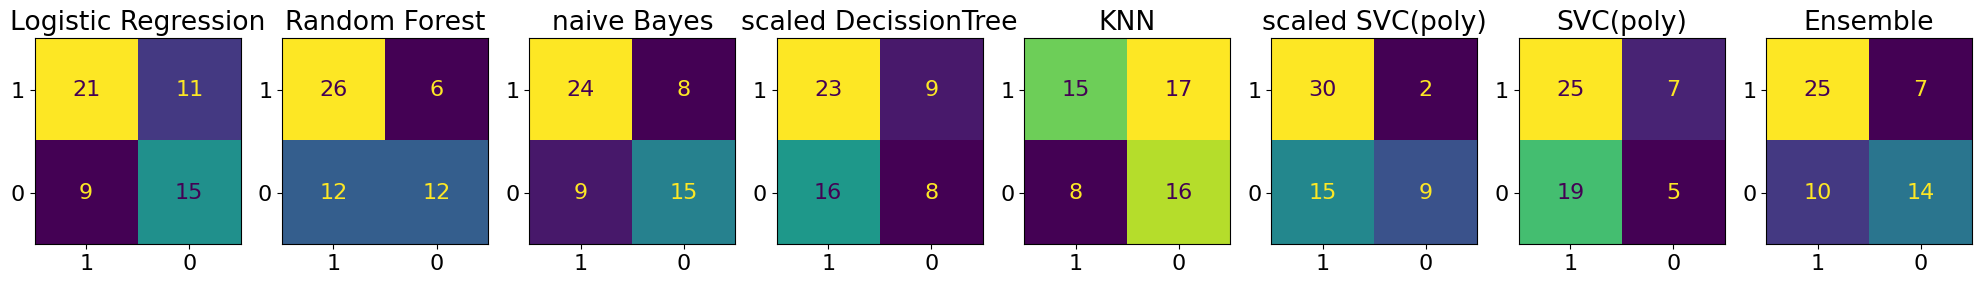

In [139]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## !!! Strain (arg-min/max) per patient from p2p df

works best for mid-cavity-segments

(56, 6)
(56, 12)
(56, 6)
(56,)
********** Logistic Regression **********
[1.         1.         1.         0.83333333 0.5       ]
Recall: 0.87 (+/- 0.19) [Logistic Regression]
Accuracy: 0.84 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.83333333 0.8        0.8        0.83333333 0.5       ]
Recall: 0.75 (+/- 0.13) [Random Forest]
Accuracy: 0.75 (+/- 0.10) [Random Forest]
********** naive Bayes **********
[1.         1.         0.6        0.66666667 0.5       ]
Recall: 0.75 (+/- 0.21) [naive Bayes]
Accuracy: 0.75 (+/- 0.06) [naive Bayes]
********** scaled DecissionTree **********
[0.83333333 0.8        0.6        0.66666667 0.33333333]
Recall: 0.65 (+/- 0.18) [scaled DecissionTree]
Accuracy: 0.68 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.83333333 0.8        0.8        0.16666667 0.5       ]
Recall: 0.62 (+/- 0.26) [KNN]
Accuracy: 0.64 (+/- 0.15) [KNN]
********** scaled SVC(poly) **********
[1.         1.         0.8        1.         0.66666

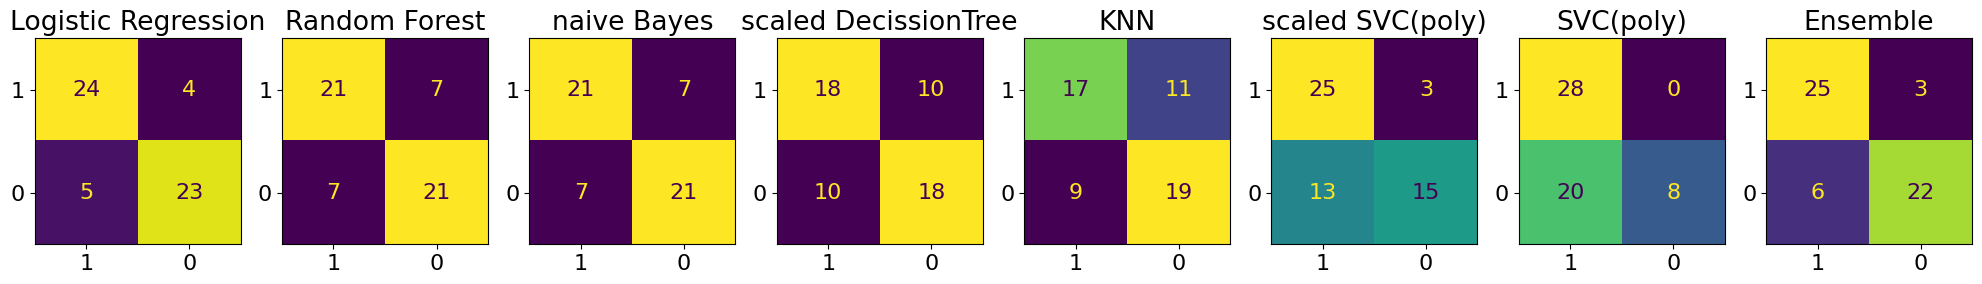

In [75]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

## (Most robust) Strains concatenatet per patient

(56, 6)
(56, 48)
(56, 6)
(56,)
********** Logistic Regression **********
[1.         0.8        1.         0.83333333 0.66666667]
Recall: 0.86 (+/- 0.13) [Logistic Regression]
Accuracy: 0.79 (+/- 0.12) [Logistic Regression]
********** Random Forest **********
[0.83333333 0.8        1.         0.83333333 0.5       ]
Recall: 0.79 (+/- 0.16) [Random Forest]
Accuracy: 0.79 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[1.         1.         0.6        0.66666667 0.5       ]
Recall: 0.75 (+/- 0.21) [naive Bayes]
Accuracy: 0.73 (+/- 0.08) [naive Bayes]
********** scaled DecissionTree **********
[0.66666667 0.6        1.         0.66666667 0.33333333]
Recall: 0.65 (+/- 0.21) [scaled DecissionTree]
Accuracy: 0.68 (+/- 0.15) [scaled DecissionTree]
********** KNN **********
[1.         0.8        0.8        0.66666667 0.5       ]
Recall: 0.75 (+/- 0.17) [KNN]
Accuracy: 0.73 (+/- 0.11) [KNN]
********** scaled SVC(poly) **********
[1.         1.         1.         1.         0.83333

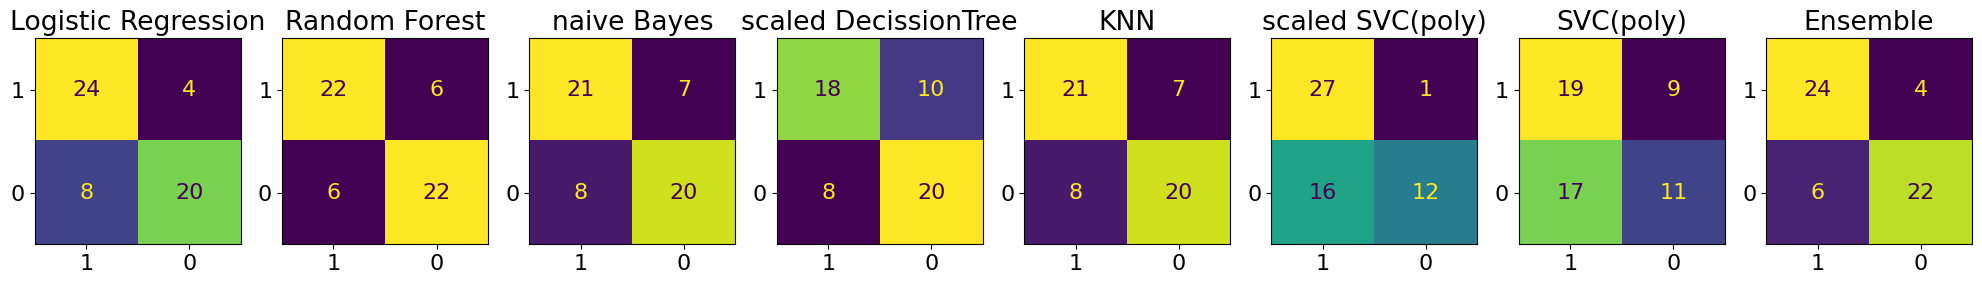

In [44]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_peak.groupby(['pat'])['pcs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_peak.groupby(['pat'])['prs_p2p_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc2 = np.stack(df_peak.groupby(['pat'])['pcs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr2 = np.stack(df_peak.groupby(['pat'])['prs_p2p_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc3 = np.stack(df_peak.groupby(['pat'])['pcs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr3 = np.stack(df_peak.groupby(['pat'])['prs_com_arg'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xc4 = np.stack(df_peak.groupby(['pat'])['pcs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr4 = np.stack(df_peak.groupby(['pat'])['prs_com_p'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr,xc2,xr2,xc3,xr3,xc4,xr4], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_peak.groupby(['pat'])['lge'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

# Strain per Segment

(224, 5)
(224, 10)
(224, 5)
(224,)
********** Logistic Regression **********
[0.63157895 0.73684211 0.78947368 0.68421053 0.68421053]
Recall: 0.71 (+/- 0.05) [Logistic Regression]
Accuracy: 0.63 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.47368421 0.36842105 0.52631579 0.21052632 0.63157895]
Recall: 0.44 (+/- 0.14) [Random Forest]
Accuracy: 0.61 (+/- 0.08) [Random Forest]
********** naive Bayes **********
[0.73684211 0.57894737 0.78947368 0.57894737 0.68421053]
Recall: 0.67 (+/- 0.08) [naive Bayes]
Accuracy: 0.59 (+/- 0.04) [naive Bayes]
********** scaled DecissionTree **********
[0.47368421 0.36842105 0.36842105 0.31578947 0.52631579]
Recall: 0.41 (+/- 0.08) [scaled DecissionTree]
Accuracy: 0.55 (+/- 0.09) [scaled DecissionTree]
********** KNN **********
[0.42105263 0.31578947 0.52631579 0.47368421 0.36842105]
Recall: 0.42 (+/- 0.07) [KNN]
Accuracy: 0.60 (+/- 0.02) [KNN]
********** scaled SVC(poly) **********
[0.42105263 0.84210526 0.89473684 0.78947368 0.8

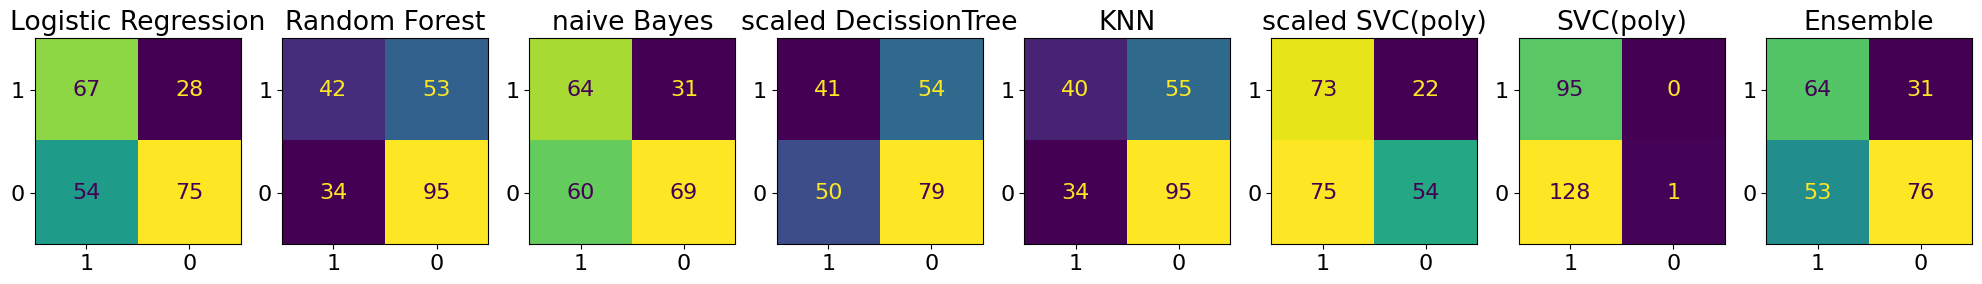

In [142]:
# per patient with peak values from the phases and argmax
xc = np.stack(df_strain_comp.groupby(['pat','aha'])['our_cs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
xr = np.stack(df_strain_comp.groupby(['pat','aha'])['our_rs'].apply(list).values).astype(np.float32) # .reshape((42,16,5))
print(xc.shape)

x = np.concatenate([xc,xr], axis=1)
print(x.shape)
# extract our target as binary vector (patient with abnormal motion == True)
y = np.stack(df_strain_comp.groupby(['pat','aha'])['lge'].apply(list).values).astype(np.float32)
print(y.shape)
y = y.sum(axis=1)>0
print(y.shape)
cross_validate_f1(x,y)

In [120]:
# check for nan and infinit values
x[~np.isfinite(x)]

array([], dtype=float32)

# Unsupervised Clustering

In [143]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#temp_2d = TSNE(n_components=2, perplexity=4, learning_rate=50).fit_transform(x)
#temp_2d = PCA(n_components=2).fit_transform(x)
temp_2d = nca = make_pipeline(
    #StandardScaler(),
    MinMaxScaler(),
    #NeighborhoodComponentsAnalysis(n_components=4, random_state=42),
    TSNE(n_components=2, perplexity=2, learning_rate=500, method='exact', init='pca')
    ).fit_transform(x)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(224, 3)


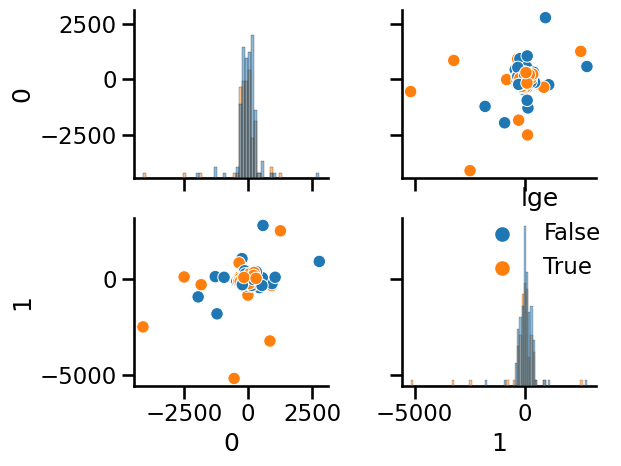

In [144]:
sb.set_context("talk")
df_temp = pd.DataFrame(temp_2d)
df_temp['lge'] = y
print(df_temp.shape)
g = sb.pairplot(data=df_temp,diag_kind="hist", hue='lge')
plt.tight_layout()
plt.show()

********** Logistic Regression **********
[0.5        0.86666667 0.53333333 0.5        0.625     ]
Recall: 0.60 (+/- 0.14) [Logistic Regression]
Accuracy: 0.63 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.3125     0.66666667 0.4        0.1875     0.5625    ]
Recall: 0.43 (+/- 0.17) [Random Forest]
Accuracy: 0.78 (+/- 0.02) [Random Forest]
********** naive Bayes **********
[0.1875     0.4        0.13333333 0.0625     0.1875    ]
Recall: 0.19 (+/- 0.11) [naive Bayes]
Accuracy: 0.78 (+/- 0.03) [naive Bayes]
********** scaled DecissionTree **********
[0.375      0.6        0.33333333 0.1875     0.5625    ]
Recall: 0.41 (+/- 0.15) [scaled DecissionTree]
Accuracy: 0.74 (+/- 0.02) [scaled DecissionTree]
********** KNN **********
[0.3125     0.33333333 0.33333333 0.0625     0.25      ]
Recall: 0.26 (+/- 0.10) [KNN]
Accuracy: 0.78 (+/- 0.02) [KNN]
********** scaled SVC(poly) **********
[0.4375     0.66666667 0.46666667 0.375      0.5       ]
Recall: 0.49 (+/- 0.10) [s

KeyboardInterrupt: 

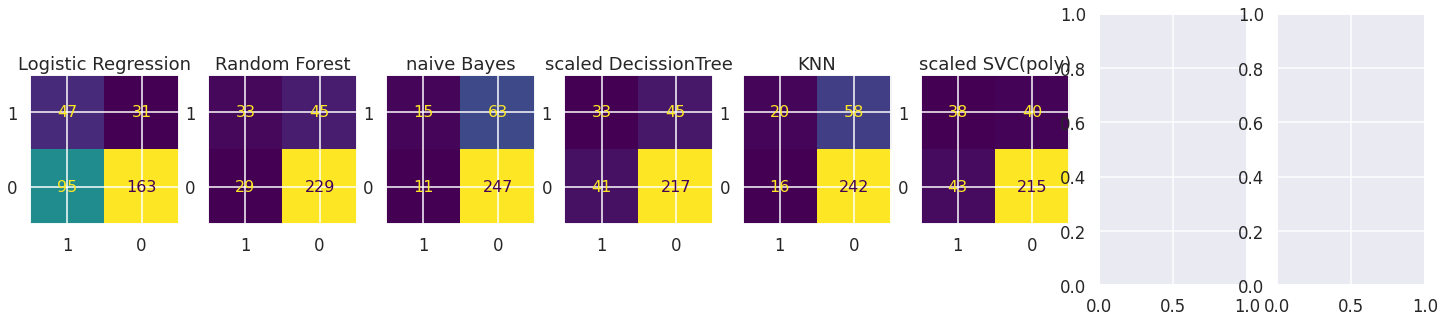

In [96]:
cross_validate_f1(temp_2d,y)

# Gridsearch for the SVC Estimator pipeline

In [153]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'clf__C', 'clf__break_ties', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])

In [76]:

def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 10, 100, 1e3, 1e4, 1e5]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,10,500,1000]

    penalties = ['l2']
    solvers = ['liblinear', 'lbfgs']

    scaler = [StandardScaler(), MinMaxScaler(), None]

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    params = [rf_params, svc_params, rf_params, et_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, param_grid=params, scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1'], refit='balanced_accuracy', n_jobs=16)
gs = create_grid_search()
gs = gs.fit(x, y)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/met

In [77]:
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

(1572, 61)

In [78]:
results.sort_values(by=['rank_test_f1','rank_test_accuracy','rank_test_recall'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_f1  mean_test_recall  mean_test_accuracy  \
671        0.8867            0.9333              0.8773   
467        0.8685            0.9000              0.8591   
692        0.8655            0.8933              0.8591   
800        0.8655            0.8933              0.8591   
920        0.8655            0.8933              0.8591   

                                                                                                                                                                                     params_str  
671  {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': None}  
467           {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': None, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}  
692             {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
800       {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
920         {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 1000.0, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'scaler': None}

In [113]:
results.sort_values(by=['rank_test_balanced_accuracy', 'rank_test_recall','rank_test_f1'])[['mean_test_recall', 
                                                                        'mean_test_accuracy', 
                                                                        'mean_test_balanced_accuracy', 
                                                                        'mean_test_average_precision',
                                                                        'mean_test_precision', 
                                                                        'mean_test_f1', 
                                                                        'params_str']].head(5)

mean_test_recall  mean_test_accuracy  mean_test_balanced_accuracy  \
671          0.933333            0.877273                     0.883333   
467          0.900000            0.859091                     0.866667   
692          0.893333            0.859091                     0.863333   
800          0.893333            0.859091                     0.863333   
920          0.893333            0.859091                     0.863333   

     mean_test_average_precision  mean_test_precision  mean_test_f1  \
671                     0.910214             0.876190      0.886667   
467                     0.916563             0.876190      0.868485   
692                     0.914937             0.866667      0.865455   
800                     0.914937             0.866667      0.865455   
920                     0.914937             0.866667      0.865455   

                                                                                                                                                                                     params_str  
671  {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': None}  
467           {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': None, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': None}  
692             {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
800       {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}  
920         {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 1000.0, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'rbf', 'scaler': None}

## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



params: {'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': None}
[1.         1.         1.         1.         0.66666667]
Recall: 0.93 (+/- 0.13) []
Accuracy: 0.88 (+/- 0.10) []
Precision: 0.88 (+/- 0.15) []
Balanced Accuracy: 0.88 (+/- 0.10) []
F1: 0.89 (+/- 0.09) []
AUC: 0.88


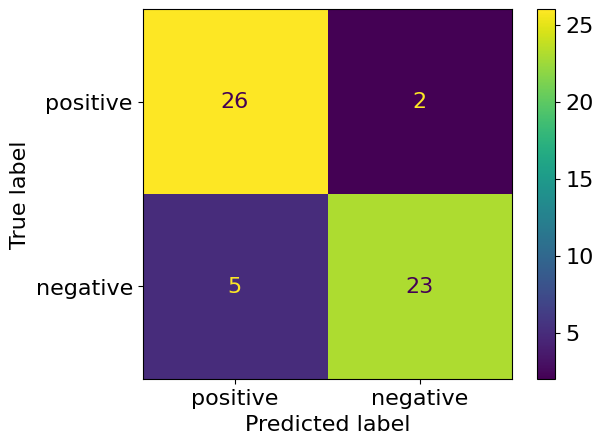

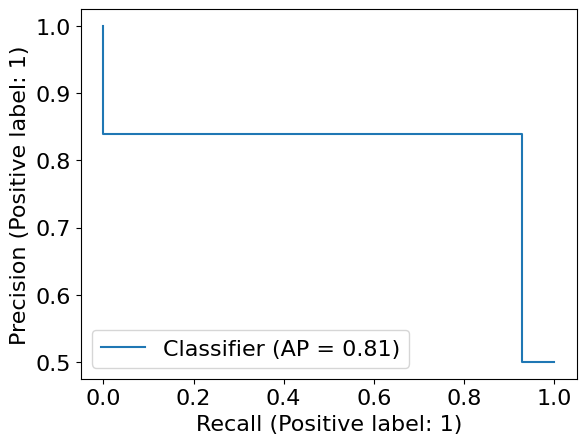

In [79]:
def plot_report(clf, x, y, label=''):
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    y_pred = cross_val_predict(clf, x, y, cv=5)
    scores = cross_validate(clf, x, y, scoring=['recall', 'accuracy', 'balanced_accuracy', 'precision', 'f1'], cv=5)
    print('params: {}'.format(label))
    print(scores['test_recall'])
    print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), ""))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std(), ""))
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores['test_precision'].mean(), scores['test_precision'].std(), ""))
    print("Balanced Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), ""))
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), ""))
    print('AUC: {:.2f}'.format(sklearn.metrics.roc_auc_score(y,y_pred)))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)
    
plot_report(gs.best_estimator_, x, y, label=gs.best_params_)

In [98]:
print(gs.best_params_)
best_clf

{'clf': SVC(C=10, class_weight='balanced', gamma=0.01), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'scaler': None}


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))])

params: [('scaler', StandardScaler()), ('clf', SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'))]
[1.         0.85714286 1.         1.         0.85714286]
Recall: 0.94 (+/- 0.07) []
Accuracy: 0.65 (+/- 0.06) []
Precision: 0.64 (+/- 0.07) []
Balanced Accuracy: 0.60 (+/- 0.06) []
F1: 0.76 (+/- 0.03) []


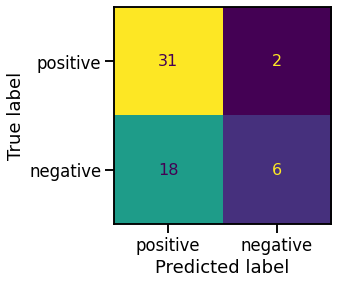

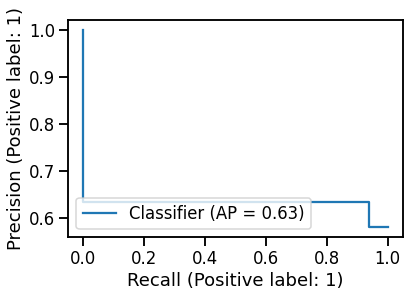

In [47]:
# Best pipeline according to the balanced accuracy
#{'clf': SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'), 'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__gamma': 0.01, 'clf__kernel': 'sigmoid', 'scaler': StandardScaler()}
best_clf = Pipeline(steps=[('scaler',StandardScaler(),),('clf',SVC(C=0.1, class_weight='balanced', gamma=0.01, kernel='sigmoid'),)])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

params: [('scaler', StandardScaler()), ('clf', SVC(C=10, gamma=0.01, kernel='poly'))]
[0.85714286 0.71428571 1.         1.         1.        ]
Recall: 0.91 (+/- 0.11) []
Accuracy: 0.60 (+/- 0.12) []
Precision: 0.60 (+/- 0.09) []
Balanced Accuracy: 0.55 (+/- 0.12) []
F1: 0.72 (+/- 0.09) []


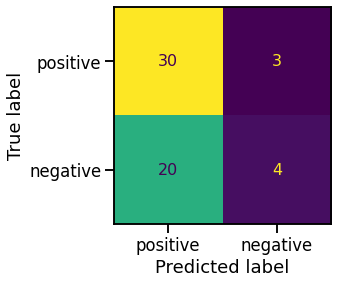

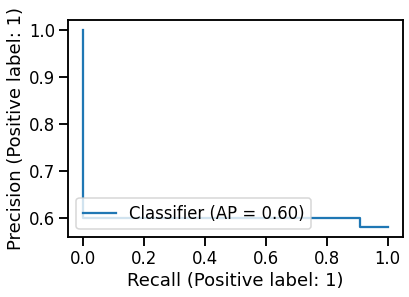

In [48]:
# this one has the highest recall == 1, but no real information gain
best_clf = Pipeline(steps=[('scaler',StandardScaler(),),('clf',SVC(C=10, class_weight=None, gamma=0.01, kernel='poly'),)])
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[1.         0.8        0.8        0.66666667 0.5       ]
Recall: 0.75 (+/- 0.17) []
Accuracy: 0.71 (+/- 0.07) []
Precision: 0.72 (+/- 0.09) []
Balanced Accuracy: 0.72 (+/- 0.06) []
F1: 0.72 (+/- 0.08) []


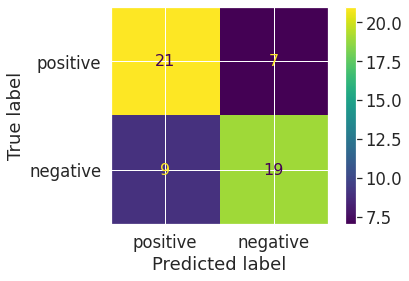

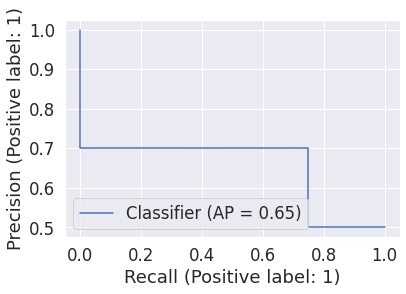

In [27]:
# this one has a high recall, but still a valid accuracy
best_clf = make_pipeline(StandardScaler(), SVC(kernel='linear',gamma='scale',class_weight='balanced', C=1, degree=3))
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

params: [('standardscaler', StandardScaler()), ('svc', SVC(C=1, class_weight='balanced', kernel='linear'))]
[1.         0.8        0.8        0.66666667 0.5       ]
Recall: 0.75 (+/- 0.17) []
Accuracy: 0.71 (+/- 0.07) []
Precision: 0.72 (+/- 0.09) []
Balanced Accuracy: 0.72 (+/- 0.06) []
F1: 0.72 (+/- 0.08) []


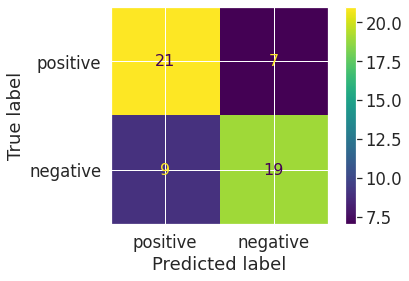

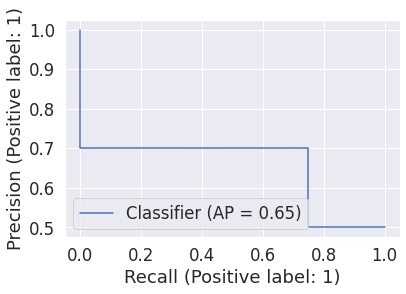

In [28]:
plot_report(best_clf, x, y, label=best_clf.get_params()['steps'])

# Model Essemble according to different metrics

In [30]:
# best balanced accuracy
results.sort_values(by='rank_test_balanced_accuracy', inplace=True, ascending=True)
params_best_ba = results.head(1)['params'].values[0]
print(params_best_ba)
clf_best_ba = gs.best_estimator_.set_params(**params_best_ba)

{'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': None}


In [31]:
# best f1
results.sort_values(by='rank_test_f1', inplace=True,ascending=True)
params_best_f1 = results.head(1)['params'].values[0]
print(params_best_f1)
clf_best_f1 = gs.best_estimator_.set_params(**params_best_f1)

{'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': None}


In [32]:
# best average precision
results.sort_values(by='rank_test_precision', inplace=True,ascending=True)
params_best_ap = results.head(1)['params'].values[0]
print(params_best_ap)
clf_best_ap = gs.best_estimator_.set_params(**params_best_ap)

{'clf': SVC(C=10, class_weight='balanced', gamma='auto', kernel='sigmoid'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': None}


In [33]:
eclf = VotingClassifier(
        estimators=[
            ('ba', clf_best_ba), 
            ('f1', clf_best_f1),
            ('ap', clf_best_ap)
                   ],
        voting='hard')

params: ensamble
[1.         1.         1.         1.         0.66666667]
Recall: 0.93 (+/- 0.13) []
Accuracy: 0.88 (+/- 0.10) []
Precision: 0.88 (+/- 0.15) []
Balanced Accuracy: 0.88 (+/- 0.10) []
F1: 0.89 (+/- 0.09) []


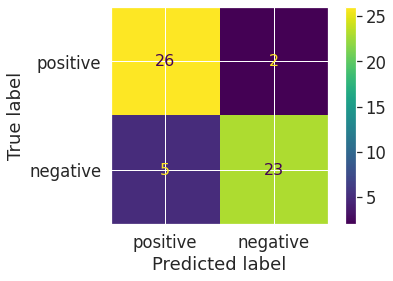

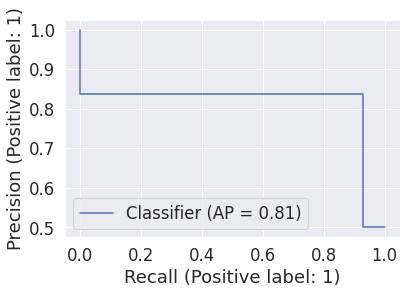

In [34]:
plot_report(eclf, x, y, label='ensamble')

Precision: 0.74
Recall: 0.81
F1 Score: 0.78
Accuracy: 0.73
Balanced accuracy: 0.72
AUC: 0.72


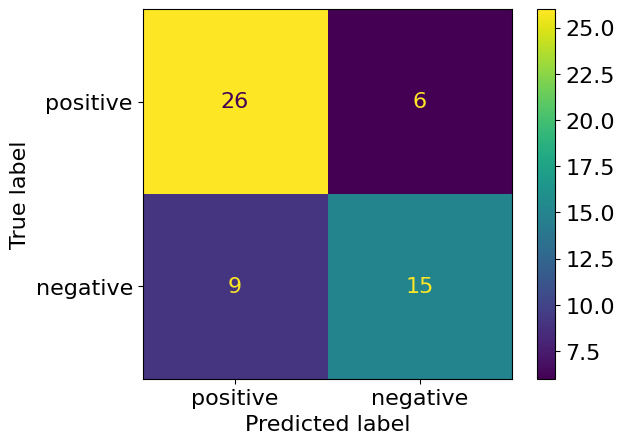

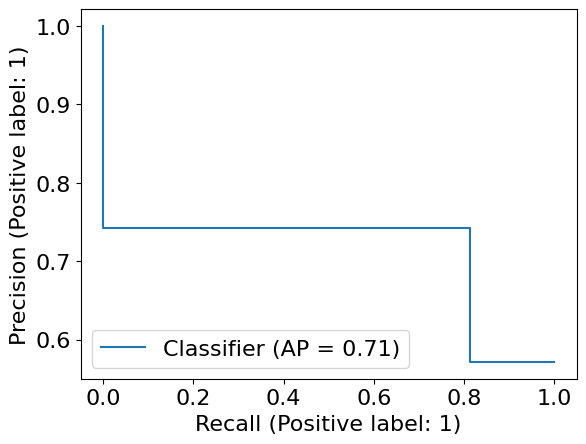

In [73]:
# re-calculate the scores of the current best clinical practice
from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)

TP = 26
FN = 6
FP = 9
TN = 15

tp = [1]*TP
y_pred = tp
y = tp

tn = [0]*TN
y_pred = y_pred + tn
y = y + tn

fp_pred = [1]*FP
fp_y = [0]*FP
y_pred = y_pred + fp_pred
y = y + fp_y

fn_pred = [0]*FN
fn_y = [1]*FN
y_pred = y_pred + fn_pred
y = y + fn_y


import sklearn
CBP_results = sklearn.metrics.precision_recall_fscore_support(y,y_pred, average='binary')
print('Precision: {:.2f}\nRecall: {:.2f}'.format(CBP_results[0], CBP_results[1]))
print('F1 Score: {:.2f}'.format(sklearn.metrics.f1_score(y,y_pred)))
print('Accuracy: {:.2f}'.format(sklearn.metrics.accuracy_score(y,y_pred)))
print('Balanced accuracy: {:.2f}'.format(sklearn.metrics.balanced_accuracy_score(y,y_pred)))
print('AUC: {:.2f}'.format(sklearn.metrics.roc_auc_score(y,y_pred)))
disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
disp = PrecisionRecallDisplay.from_predictions(y,y_pred)


# calculate the measures for the Current best practice



# Precision = TP / (TP+FP) 
